In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Timestamp
from tqdm import tqdm


# Reading the data

In [38]:
data_df = pd.read_csv('crspm_and_predictors.csv')
data_df

,permno,yyyymm,prc,ret,Price,Size,STreversal,MaxRet,High52,RealizedVol,...,MomSeason06YrPlus,MomOffSeason06YrPlus,grcapx,EntMult,Investment,PctTotAcc,EarnSupBig,EarningsSurprise,BetaTailRisk,CBOperProf
0,10659,199102,-0.17188,-15.3846,1.760959,-8.844859,15.3846,0.000000,0.407414,-0.035295,...,NaN,NaN,0.799007,NaN,NaN,0.795044,-0.379424,-0.109776,NaN,-0.371791
1,10659,199103,-0.10938,-36.3636,2.212927,-8.392890,36.3636,0.000000,0.259268,-0.065733,...,NaN,NaN,0.799007,NaN,NaN,0.795044,-0.483346,-0.109776,NaN,-0.371791
2,10659,199104,-0.21875,100.0000,1.519826,-9.085992,-100.0000,-0.571429,0.518512,-0.127870,...,NaN,NaN,0.802281,NaN,-0.043613,0.439730,-0.470160,-0.050594,NaN,-0.138481
3,10659,199105,-0.21875,0.0000,1.519826,-9.085992,0.0000,-0.142857,0.518512,-0.045962,...,NaN,NaN,0.802281,NaN,-0.046697,0.439730,-0.498256,-0.050594,NaN,-0.138481
4,10659,199106,-0.20313,-7.1429,1.593909,-9.011908,7.1429,0.000000,0.481488,-0.015972,...,NaN,NaN,0.802281,NaN,-0.050251,0.439730,-0.116901,-0.050594,NaN,-0.138481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994023,10232,198604,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4994024,10274,198604,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4994025,10301,198604,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4994026,10326,198605,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
rf_rates = pd.read_csv('TB3MS.csv')
rf_rates

,observation_date,TB3MS
0,1934-01-01,0.72
1,1934-02-01,0.62
2,1934-03-01,0.24
3,1934-04-01,0.15
4,1934-05-01,0.16
...,...,...
1089,2024-10-01,4.51
1090,2024-11-01,4.42
1091,2024-12-01,4.27
1092,2025-01-01,4.21


In [40]:
rf_rates['observation_date'] = pd.to_datetime(rf_rates['observation_date'], format='%Y-%m-%d')
data_df['date_original'] = data_df['yyyymm']
data_df['yyyymm'] = pd.to_datetime(data_df['yyyymm'], format='%Y%m') #df.loc[:, 'yyyymm']

In [41]:
# df_init = pd.merge(data_df, rf_rates, left_on='yyyymm',
#                         right_on='observation_date', how='left')

# df_init.drop(columns=['observation_date'], inplace=True)
# df_init.rename(columns={'TB3MS': 'RiskFree', 'yyyymm': 'date'}, inplace=True)
# df_init['ExcessReturn'] = df_init['ret'] - df_init['RiskFree']
# df_init.reset_index(drop=True, inplace=True)

# not_pred = ['permno', 'date', 'prc', 'ret', 'Price', 'RiskFree', 'ExcessReturn']
# pred = [c for c in df_init.columns if c not in not_pred]

# x = df_init.drop(columns=not_pred).copy()
# y = df_init['ExcessReturn'].copy()
# correlations = x.corrwith(y)
# correlations.sort_values(ascending=False, inplace=True)

# correlations


# Sampling

In [42]:
data_df.shape

data_df['date_original'] 
data_df['year'] = data_df['date_original'] // 100
yearly_counts = data_df.groupby('year').size().reset_index(name='count')
yearly_counts



,year,count
0,1960,13433
1,1961,13713
2,1962,20268
3,1963,25037
4,1964,25591
...,...,...
60,2020,97136
61,2021,109842
62,2022,118905
63,2023,118501


In [43]:
# Count the number of periods each firm appears in
firm_period_counts = data_df.groupby('permno')['yyyymm'].nunique()

# Find firms with complete or nearly complete data
total_periods = data_df['yyyymm'].nunique()
min_periods_threshold = int(total_periods * 0.55)

complete_firms = firm_period_counts[firm_period_counts >= min_periods_threshold].index.tolist()
print(f"Found {len(complete_firms)} firms with at least {min_periods_threshold} periods of data (out of {total_periods} total periods)")

# # For these firms, calculate the percentage of non-NaN values for each feature
# filtered_df = data_df[data_df['permno'].isin(complete_firms)]

# # Calculate the percentage of non-NaN values for each firm across all features
# feature_cols = data_df.columns.drop(['permno', 'yyyymm'])
# nan_percentages = filtered_df.groupby('permno')[feature_cols].apply(
#     lambda x: (1 - x.isna().mean()) * 100
# ).mean(axis=1)  # Average across all features

# # Filter firms with high data quality
# data_quality_threshold = 65
# high_quality_firms = nan_percentages[nan_percentages >= data_quality_threshold].index.tolist()
# print(f"Found {len(high_quality_firms)} firms with at least {data_quality_threshold}% non-NaN values")

# Get the final filtered dataframe
#final_df = data_df[data_df['permno'].isin(complete_firms)].copy()
NUM_ROWS = 5000000
NUM_ROWS_5M = 5000000
NUM_ROWS_600k = 600000
NUM_ROWS_1M = 1000000
final_df = data_df.sort_values(by='date_original', ascending=False).head(NUM_ROWS_1M) # decreasing order

print(f"Original dataframe shape: {data_df.shape} Original Min Date {data_df['yyyymm'].min()} Original Max Date {data_df['yyyymm'].max()}")
print(f"Filtered dataframe shape: {final_df.shape} Filtered Min Date {final_df['yyyymm'].min()} Filtered Max Date {final_df['yyyymm'].max()}")

Found 1543 firms with at least 429 periods of data (out of 780 total periods)
Original dataframe shape: (4994028, 121) Original Min Date 1960-01-01 00:00:00 Original Max Date 2024-12-01 00:00:00
Filtered dataframe shape: (1000000, 121) Filtered Min Date 2015-04-01 00:00:00 Filtered Max Date 2024-12-01 00:00:00


In [44]:
yearly_counts_filtered = final_df.groupby('year').size().reset_index(name='count')
yearly_counts_filtered

,year,count
0,2015,62375
1,2016,91621
2,2017,92119
3,2018,93931
4,2019,95373
5,2020,97136
6,2021,109842
7,2022,118905
8,2023,118501
9,2024,120197


In [45]:
final_df = final_df.drop('date_original', axis=1)



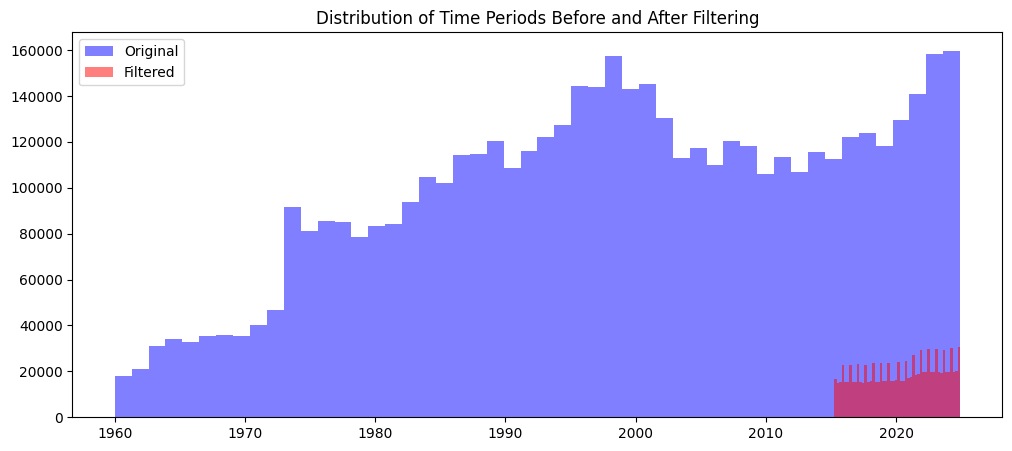

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.hist(data_df['yyyymm'], bins=50, alpha=0.5, label="Original", color='blue')
plt.hist(final_df['yyyymm'], bins=50, alpha=0.5, label="Filtered", color='red')
plt.legend()
plt.title("Distribution of Time Periods Before and After Filtering")
plt.show()


In [47]:
final_df.sort_values(by=['yyyymm'], inplace=True)
final_df.reset_index(drop=True, inplace=True)

final_df

,permno,yyyymm,prc,ret,Price,Size,STreversal,MaxRet,High52,RealizedVol,...,MomOffSeason06YrPlus,grcapx,EntMult,Investment,PctTotAcc,EarnSupBig,EarningsSurprise,BetaTailRisk,CBOperProf,year
0,91138,2015-04-01,14.2100,0.7032,-2.653946,-11.696932,-0.7032,-0.004249,0.869113,-0.001751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
1,15154,2015-04-01,25.1000,-0.8101,-3.222868,-8.926650,0.8101,-0.009505,0.977986,-0.005805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
2,86573,2015-04-01,24.8500,2.8134,-3.212858,-11.135844,-2.8134,-0.062869,0.995992,-0.021369,...,0.002047,0.487931,-5.486493,-0.559850,-2.664762,0.060186,-0.913608,0.130374,NaN,2015
3,87310,2015-04-01,2.4200,-4.7244,-0.883768,-10.756693,4.7244,-0.065574,0.657609,-0.029064,...,NaN,0.914195,NaN,-0.125770,0.145226,-0.875374,0.869530,2.033735,NaN,2015
4,15194,2015-04-01,15.7500,-1.8692,-2.756840,-12.849625,1.8692,-0.009963,0.954545,-0.008982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,22980,2024-12-01,26.1900,-1.5103,-3.265378,-15.296502,1.5103,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
999996,23163,2024-12-01,28.9797,-5.0570,-3.366596,-8.194909,5.0570,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
999997,23052,2024-12-01,0.4850,25.0000,0.723606,-9.241164,-25.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
999998,88203,2024-12-01,18.5400,2.3179,-2.919931,-13.465035,-2.3179,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.279271,-0.840397,NaN,NaN,NaN,NaN,2024


In [48]:
df = final_df.copy()
# df.to_csv('cleaned_sample.csv', index=False)
# df = df[(df['yyyymm'] >= '1995-01-01') &
#         (df['yyyymm'] <= '2000-12-01')]
# df.reset_index(drop=True, inplace=True)

In [49]:
#remove later
# df = pd.read_csv('cleaned_sample.csv')

In [50]:
#remove later

rf_rates['observation_date'] = pd.to_datetime(rf_rates['observation_date'], format='%Y-%m-%d')
df['yyyymm'] = pd.to_datetime(df['yyyymm'], format='%Y-%m-%d')

# Functions

In [51]:
def estimate_beta_and_save_predictions(df, train_indices, test_indices):
    """
    Estimate beta using training data and save CAPM predictions for test data directly in the dataframe

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with stock returns and market returns
    train_indices : array-like
        Indices for training period
    test_indices : array-like
        Indices for test period

    Returns:
    --------
    DataFrame with beta estimates and CAPM predictions
    """
    # Create a copy of the dataframe
    result_df = df.copy()
    result_df['beta'] = np.nan
    result_df['CAPM_Predicted_ExcessReturn'] = np.nan

    # Process each stock separately
    for permno in df['permno'].unique():
        stock_data = df[df['permno'] == permno]

        # Get training data for this stock
        train_data = stock_data[stock_data.index.isin(train_indices)]

        if len(train_data) > 10:  # Require minimum observations
            # Calculate beta based on training data
            cov_stock_market = np.cov(train_data['ExcessReturn'], train_data['MarketExcessReturn'])[0, 1]
            var_market = np.var(train_data['MarketExcessReturn'])

            if var_market != 0:
                beta = cov_stock_market / var_market

                # Apply this beta to test period observations
                test_indices_for_stock = stock_data.index[stock_data.index.isin(test_indices)]
                result_df.loc[test_indices_for_stock, 'beta'] = beta

                # Calculate CAPM predictions directly
                for idx in test_indices_for_stock:
                    market_excess = result_df.loc[idx, 'MarketExcessReturn']
                    result_df.loc[idx, 'CAPM_Predicted_ExcessReturn'] = beta * market_excess

    return result_df

In [52]:
# Out of sample R2 function
def r2_oos(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum(y_true**2)

In [53]:
def split_with_percentage(df_init, features, target, date_column='date', train_size=0.6, valid_size=0.2, test_size=0.2):
    """
    Split data into train, validation, and test sets based on specified percentages

    Parameters:
    -----------
    df_init : pandas DataFrame
        The complete dataset
    features : list
        List of feature column names
    target : str
        Name of the target column
    date_column : str
        Name of the date column
    train_size : float
        Percentage of data for training (e.g., 0.6 for 60%)
    valid_size : float
        Percentage of data for validation (e.g., 0.2 for 20%)
    test_size : float
        Percentage of data for testing (e.g., 0.2 for 20%)

    Returns:
    --------
    X_train, y_train, X_valid, y_valid, X_test, y_test
    """
    assert train_size + valid_size + test_size == 1, "Train, validation, and test sizes must sum to 1"

    # Ensure date column is datetime
    df = df_init.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column])

    # Sort by date
    df = df.sort_values(by=date_column)

    # Determine split indices
    n = len(df)
    train_end = int(n * train_size)
    valid_end = train_end + int(n * valid_size)

    # Train set
    train = df.iloc[:train_end]
    X_train, y_train = train[features], train[target]

    # Validation set
    valid = df.iloc[train_end:valid_end]
    X_valid, y_valid = valid[features], valid[target]

    # Test set
    test = df.iloc[valid_end:]
    X_test, y_test = test[features], test[target]

    y_train = y_train.fillna(0)
    y_valid = y_valid.fillna(0)
    y_test = y_test.fillna(0)

    # Print summary
    print(f"Training set: {train[date_column].min().strftime('%Y-%m-%d')} to {train[date_column].max().strftime('%Y-%m-%d')}, {len(X_train)} observations")
    print(f"Validation set: {valid[date_column].min().strftime('%Y-%m-%d')} to {valid[date_column].max().strftime('%Y-%m-%d')}, {len(X_valid)} observations")
    print(f"Test set: {test[date_column].min().strftime('%Y-%m-%d')} to {test[date_column].max().strftime('%Y-%m-%d')}, {len(X_test)} observations")

    return X_train, y_train, X_valid, y_valid, X_test, y_test


In [54]:
from sklearn.preprocessing import MinMaxScaler

def clean_scale_data(X_train, X_valid, X_test):
    """
    Scales data using MinMaxScaler within range [-1, 1] and replaces NaNs with 0 before scaling.

    Parameters:
    -----------
    X_train, X_valid, X_test : pandas DataFrame
        Feature sets for training, validation, and test

    Returns:
    --------
    X_train_scaled, X_valid_scaled, X_test_scaled : pandas DataFrame
        Scaled versions of the input datasets
    """
    # Replace NaNs with 0 before scaling
    X_train = X_train.fillna(0)
    X_valid = X_valid.fillna(0)
    X_test = X_test.fillna(0)

    # Initialize scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Fit on training data and transform all splits
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns, index=X_valid.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Clip values outside [-1, 1] to enforce the range
    X_valid_scaled = X_valid_scaled.clip(-1, 1)
    X_test_scaled = X_test_scaled.clip(-1, 1)

    return X_train_scaled, X_valid_scaled, X_test_scaled


# Cleaning, scaling, adding vars

Variables: The dataset includes a unique firm identifier (permno), date,
 stock price (prc), stock return in percentage units adjusted for delisting (ret), and a variable named Signed Price (Price). In addition, there are 114 predictor variables (signals).

In [55]:
# Merge the DataFrames based on the date columns
merged_df = pd.merge(df, rf_rates, left_on='yyyymm',
                        right_on='observation_date', how='left')

In [56]:
merged_df.drop(columns=['observation_date'], inplace=True)
merged_df.rename(columns={'TB3MS': 'riskfree', 'yyyymm': 'date'}, inplace=True)
merged_df.columns = merged_df.columns.str.lower()
merged_df['ExcessReturn'] = merged_df['ret'] - merged_df['riskfree']

merged_df['MarketReturn'] = merged_df.groupby('date')['ret'].transform('mean')
merged_df['MarketExcessReturn'] = merged_df['MarketReturn'] - merged_df['riskfree']

merged_df = merged_df.replace({-np.inf: np.nan, np.inf: np.nan})
merged_df.fillna(0, inplace=True)

merged_df.sort_values(['date', 'permno'], inplace=True)
merged_df.reset_index(drop=True, inplace=True)


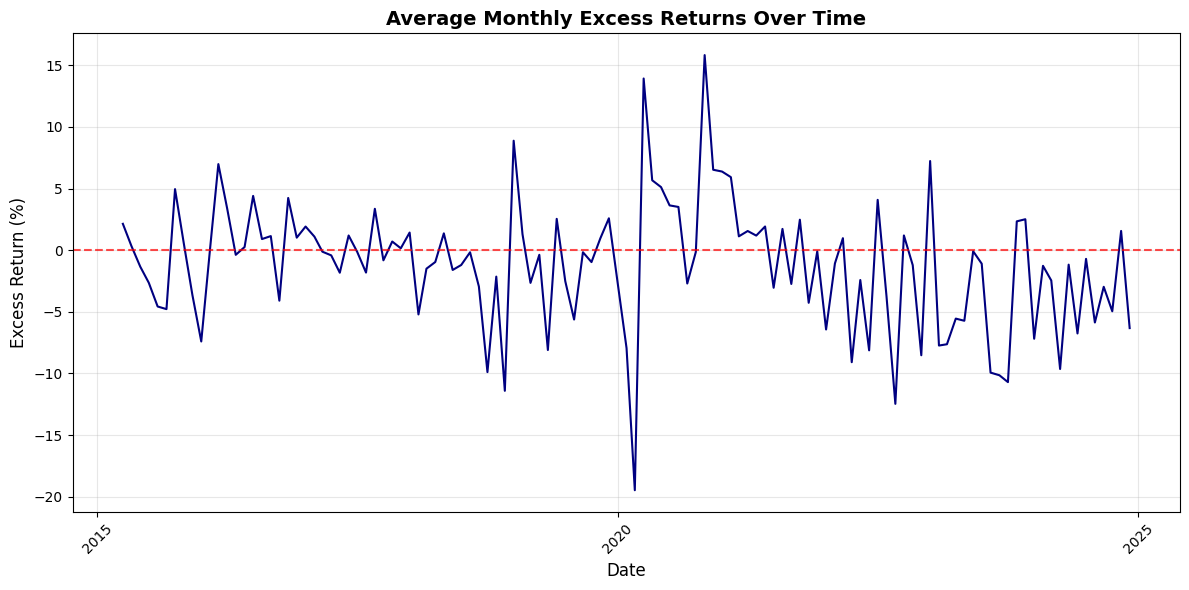

In [57]:
# Calculate monthly average excess return across all stocks
monthly_excess_returns = merged_df.groupby('date')['ExcessReturn'].mean().reset_index()

# Plot the time series
plt.figure(figsize=(12, 6))

# Plot the time series line
plt.plot(monthly_excess_returns['date'], monthly_excess_returns['ExcessReturn'],
         color='navy', linewidth=1.5)

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Format the plot
plt.title('Average Monthly Excess Returns Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Excess Return (%)', fontsize=12)
plt.grid(True, alpha=0.3)

# Format the x-axis to show years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(5))  # Show every 5 years
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

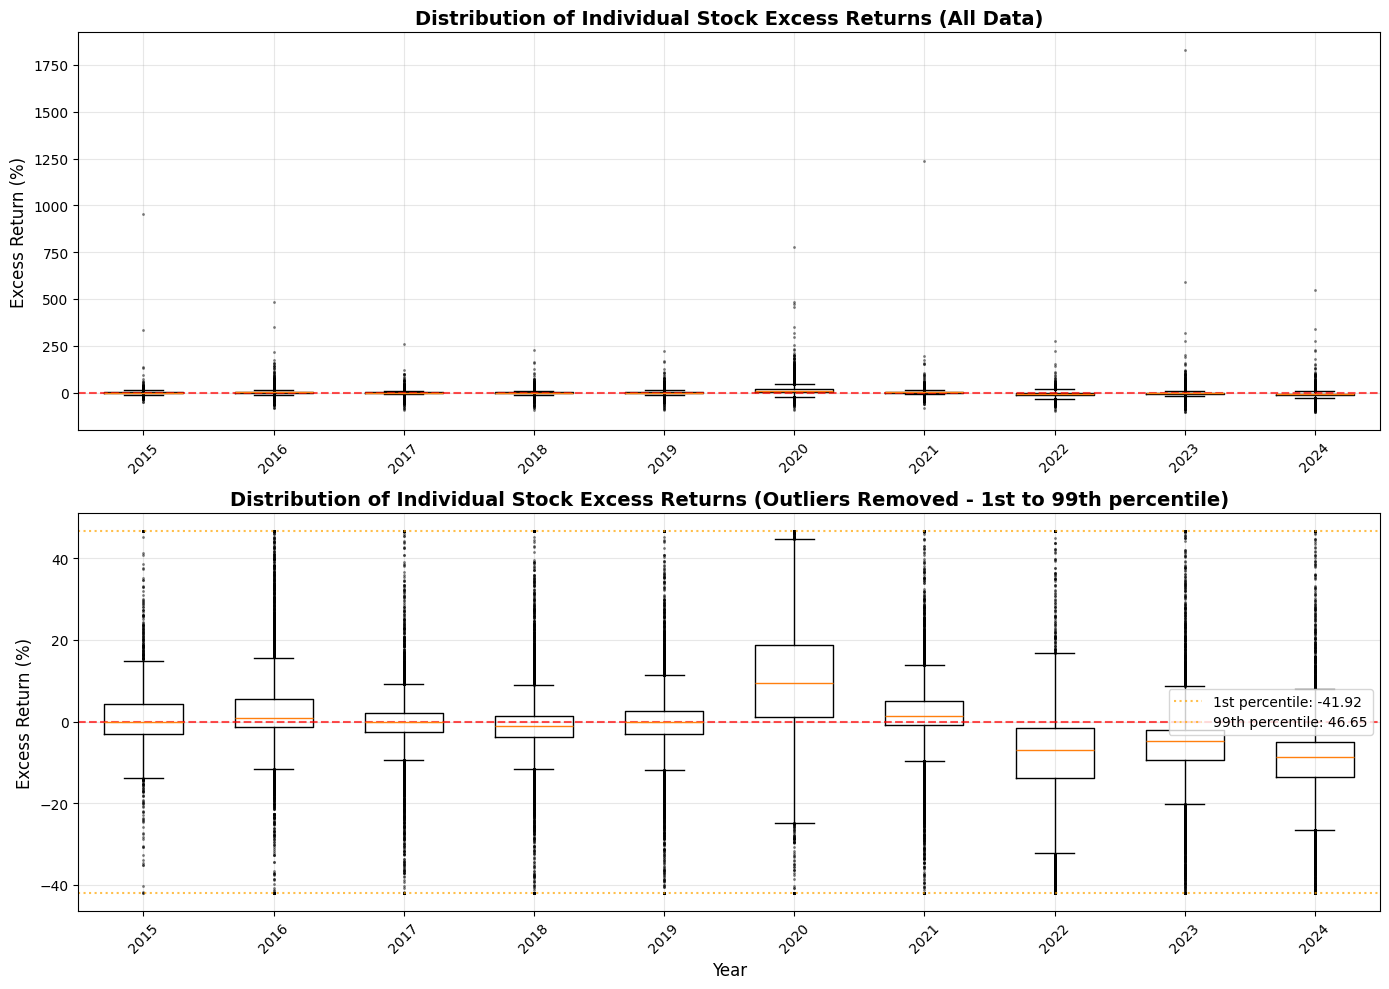

In [58]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1]})

# Sample every nth month to make the plots readable
n = 12  # sample every 12 months (annual)
sample_dates = sorted(merged_df['date'].unique())[::n]

# First subplot - Original data with all outliers
boxplot_data = []
boxplot_positions = []
date_labels = []

for i, date in enumerate(sample_dates):
    date_data = merged_df[merged_df['date'] == date]['ExcessReturn']
    if len(date_data) > 0:
        boxplot_data.append(date_data)
        boxplot_positions.append(i)
        date_labels.append(date.strftime('%Y'))

# Create boxplot in the first subplot - original data
ax1.boxplot(boxplot_data, positions=boxplot_positions, widths=0.6,
           flierprops={'marker': '.', 'markersize': 2, 'alpha': 0.5})
ax1.set_title('Distribution of Individual Stock Excess Returns (All Data)',
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Excess Return (%)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(boxplot_positions)
ax1.set_xticklabels(date_labels, rotation=45)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Second subplot - Data with outliers removed
filtered_boxplot_data = []

# Calculate overall percentiles for consistent clipping across all dates
all_returns = merged_df['ExcessReturn'].dropna()
q_low = all_returns.quantile(0.01)  # 1st percentile
q_high = all_returns.quantile(0.99)  # 99th percentile

for i, date in enumerate(sample_dates):
    date_data = merged_df[merged_df['date'] == date]['ExcessReturn']
    if len(date_data) > 0:
        # Clip values to remove outliers
        filtered_data = np.clip(date_data, q_low, q_high)
        filtered_boxplot_data.append(filtered_data)

# Create boxplot in the second subplot - filtered data
ax2.boxplot(filtered_boxplot_data, positions=boxplot_positions, widths=0.6,
           flierprops={'marker': '.', 'markersize': 2, 'alpha': 0.5})
ax2.set_title(f'Distribution of Individual Stock Excess Returns (Outliers Removed - 1st to 99th percentile)',
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Excess Return (%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(boxplot_positions)
ax2.set_xticklabels(date_labels, rotation=45)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Add horizontal lines to show clipping thresholds
ax2.axhline(y=q_low, color='orange', linestyle=':', alpha=0.7,
           label=f'1st percentile: {q_low:.2f}')
ax2.axhline(y=q_high, color='orange', linestyle=':', alpha=0.7,
           label=f'99th percentile: {q_high:.2f}')
ax2.legend()

plt.tight_layout()
plt.show()

In [59]:
predictor_vars = [c for c in merged_df.columns if c not in ['permno', 'date', 'prc', 'ret',	'price', 'riskfree', 'ExcessReturn', 'MarketReturn', 'MarketExcessReturn']]
len(predictor_vars)

115

In [60]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_with_percentage(
    df_init=merged_df,
    features=predictor_vars,
    target='ExcessReturn',
    date_column='date',
    train_size=0.3,
    valid_size=0.15,
    test_size=0.55
)


Training set: 2015-04-01 to 2018-07-01, 300000 observations
Validation set: 2018-07-01 to 2020-02-01, 150000 observations
Test set: 2020-02-01 to 2024-12-01, 550000 observations


In [61]:
X_train_scaled, X_valid_scaled, X_test_scaled = clean_scale_data(X_train, X_valid, X_test)

In [62]:
# # make some plots with features
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.heatmap(merged_df.corr(), ax=ax, cmap='coolwarm', center=0)
# plt.title('Correlation Heatmap of Features')
# plt.show()


# CAPM

In [63]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Get the indices from your split
train_indices = X_train.index
valid_indices = X_valid.index
test_indices = X_test.index

train_valid_indices = np.concatenate([train_indices, valid_indices])

# Apply the function to calculate beta and save predictions
merged_df_capm = estimate_beta_and_save_predictions(merged_df, train_valid_indices, test_indices)

# Use merged_df_capm instead of merged_df for test_data
test_data = merged_df_capm.loc[test_indices].dropna(subset=['ExcessReturn', 'CAPM_Predicted_ExcessReturn'])

r_squared_capm = r2_oos(test_data['ExcessReturn'], test_data['CAPM_Predicted_ExcessReturn'])
mae_capm = mean_absolute_error(test_data['ExcessReturn'], test_data['CAPM_Predicted_ExcessReturn'])
mse_capm = mean_squared_error(test_data['ExcessReturn'], test_data['CAPM_Predicted_ExcessReturn'])

print(f"CAPM Model Performance on Test Set:")
print(f"R² = {r_squared_capm:.4f}")
print(f"MAE = {mae_capm:.4f}")
print(f"MSE = {mse_capm:.4f}")


CAPM Model Performance on Test Set:
R² = 0.0729
MAE = 8.6734
MSE = 325.4701


In [64]:
test_indices

Index([446980, 446982, 447324, 447323, 447322, 447321, 447320, 447319, 447318,
       447317,
       ...
       993240, 993242, 993243, 993244, 993245, 993246, 993247, 993248, 993241,
       999999],
      dtype='int64', length=550000)

In [65]:
X_test

,size,streversal,maxret,high52,realizedvol,idiovol3f,returnskew3f,returnskew,idiovolaht,zerotrade1m,...,momoffseason06yrplus,grcapx,entmult,investment,pcttotacc,earnsupbig,earningssurprise,betatailrisk,cboperprof,year
446980,-9.552115,8.7738,-0.022645,0.891697,-0.018036,-0.003176,1.100944,0.913945,-0.003612,1.506532e-08,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2020
446982,-9.379254,8.8904,-0.015903,0.890105,-0.016062,-0.002162,2.708607,1.259488,-0.002947,1.500000e+01,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2020
447324,-13.692788,14.5362,-0.016384,0.829308,-0.021123,-0.014860,0.994105,1.257450,-0.021011,1.308607e-08,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2020
447323,-12.930718,-1.3752,-0.003902,1.006829,-0.002264,-0.001810,0.049644,0.348440,-0.002638,3.094677e-08,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2020
447322,-10.160917,9.5448,-0.016792,0.870979,-0.016406,-0.002227,0.632370,1.071102,-0.002965,5.758858e-09,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993246,-11.891020,-22.3137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.000000,0.615299,0.0,0.0,0.0,0.0,2024
993247,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,-0.577894,0.572024,0.0,0.0,0.0,0.0,2024
993248,-14.121803,6.8563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,-2.397486,6.327876,0.0,0.0,0.0,0.0,2024
993241,-11.031481,8.4507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,-0.402162,0.738217,0.0,0.0,0.0,0.0,2024


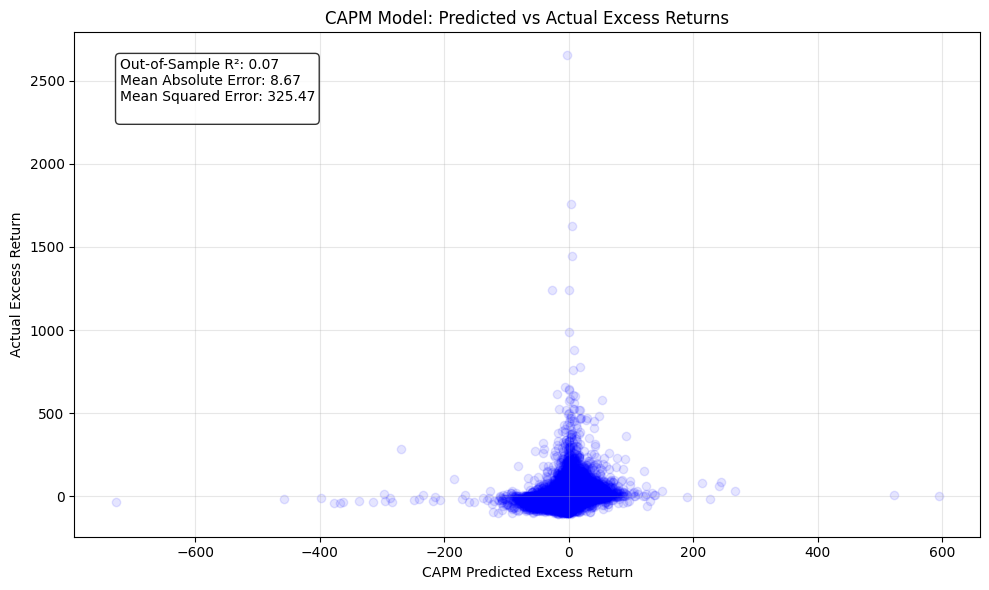

In [66]:
plt.figure(figsize=(10, 6))

# Get the test data and drop rows with missing values
test_data = merged_df_capm.loc[test_indices]

# Create the scatter plot
plt.scatter(test_data['CAPM_Predicted_ExcessReturn'],
           test_data['ExcessReturn'],
           alpha=0.1,  # Make points semi-transparent due to potential overlap
           color='blue')

metrics_text = (
    f"Out-of-Sample R²: {r_squared_capm:.2f}\n"
    f"Mean Absolute Error: {mae_capm:.2f}\n"
    f"Mean Squared Error: {mse_capm:.2f}\n"
)

plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


# Add a title and labels
plt.title('CAPM Model: Predicted vs Actual Excess Returns')
plt.xlabel('CAPM Predicted Excess Return')
plt.ylabel('Actual Excess Return')

# Add a grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CAPM:  E[return] = risk_free + betta*(E[market_ret] - risk_free)


E[market_ret] - risk_free is market risk premium

Important observations:

- Scale Discrepancy: Yes, there's a significant scale difference between the predicted and actual values. While CAPM predictions mostly fall within about -60 to +60, the actual excess returns have extreme outliers reaching up to 1750. This indicates that CAPM fails to capture extreme market movements.
- Concentration around Zero: The majority of points form a dense cloud centered around zero for both predicted and actual returns. This suggests that most of the time, both CAPM predictions and actual returns are modest in magnitude.
- Poor Predictive Power: There's only a very weak relationship between the predicted and actual values. If CAPM were a perfect predictor, points would follow a diagonal line from bottom-left to top-right. Instead, we see an almost horizontal elliptical cloud, suggesting that CAPM predictions have limited ability to explain variation in actual returns.
- Asymmetric Outliers: The presence of extreme positive outliers (actual returns reaching 1750) but no corresponding extreme negative outliers might indicate either a data issue or a real phenomenon where stocks can experience dramatic upside movement that the CAPM model completely fails to anticipate.
- Prediction Range: CAPM's predictions are much more conservative than the actual volatility observed in the market. The model predicts within a narrower band than what actually occurs.

This graph illustrates a classic challenge in financial modeling - linear models like CAPM struggle to capture the fat-tailed nature of financial returns. This is precisely why machine learning approaches that can model nonlinear relationships might offer significant improvements over traditional CAPM.

# --------------------------

# ML models

In [67]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import time
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance
import matplotlib.gridspec as gridspec
from sklearn.model_selection import PredefinedSplit, ParameterGrid
from joblib import Parallel, delayed


In [68]:

# # Check for GPU availability
# try:
#     import torch
#     gpu_available = torch.cuda.is_available()
#     if gpu_available:
#         gpu_name = torch.cuda.get_device_name(0)
# except ImportError:
#     gpu_available = False


# Functions

In [69]:
def evaluate_model(model, model_name, X_train, y_train, X_valid, y_valid, X_test, y_test):
    print(f"---{model_name} Evaluation---")

    print(f"\nTraining...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")

    train_pred = model.predict(X_train)

    print("\nGenerating predictions...")
    start_time = time.time()
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)
    pred_time = time.time() - start_time
    print(f"Prediction completed in {pred_time:.2f} seconds")

    print("\nCalculating metrics...")
    results = {
        'train_mse': mean_squared_error(y_train, train_pred),
        'train_r2_oos': r2_oos(y_train, train_pred),
        'valid_mse': mean_squared_error(y_valid, valid_pred),
        'valid_r2_oos': r2_oos(y_valid, valid_pred),
        'test_mse': mean_squared_error(y_test, test_pred),
        'test_r2_oos': r2_oos(y_test, test_pred),
        'train_time': train_time,
        'pred_time': pred_time #test + valid
    }

    results['train_pred'] = train_pred
    results['valid_pred'] = valid_pred
    results['test_pred'] = test_pred

    print(f"""Train R² OOS: {results['train_r2_oos']:.2f} \nValidation R² OOS: {results['valid_r2_oos']:.2f} \nTest R² OOS: {results['test_r2_oos']:.2f}
              """)

    return results

In [70]:
# Assuming X_train is your preprocessed training data
# (the data should be standardized before PCA)

def plot_pca_explained_variance(X, max_components=None):
    """
    Create a PCA explained variance plot to help choose the number of components.
    """
    # Determine maximum number of components
    if max_components is None:
        max_components = min(X.shape[0], X.shape[1])
    else:
        max_components = min(max_components, min(X.shape[0], X.shape[1]))

    # Fit PCA
    pca = PCA(n_components=max_components)
    pca.fit(X)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-', linewidth=2)
    plt.grid(True, alpha=0.6)
    plt.xlabel('Number of Components', fontsize=12)
    plt.ylabel('Cumulative Explained Variance', fontsize=12)
    plt.title('PCA Explained Variance', fontsize=14)

    if len(cumulative_variance) > 10:  # Only calculate elbow if we have enough points
        # Calculate approximate second derivative (discrete)
        diffs = np.diff(cumulative_variance, 2)
        elbow_index = np.argmin(diffs) + 2  # +2 because of two diff operations

        # Mark the elbow point
        plt.plot(elbow_index + 1, cumulative_variance[elbow_index], 'ko', markersize=8)
        plt.axvline(x=elbow_index + 1, color='k', linestyle='--', alpha=0.7)
        plt.annotate(f'Elbow: {elbow_index + 1} components\n({cumulative_variance[elbow_index]:.2f} variance)',
                    xy=(elbow_index + 1, cumulative_variance[elbow_index]),
                    xytext=(elbow_index + 10, cumulative_variance[elbow_index] - 0.1),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5)
    plt.annotate('95% explained variance',
                xy=(max_components/2, 0.95),
                xytext=(max_components/2, 0.9),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
                ha='center')

    plt.tight_layout()
    plt.show()

    return {
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance': cumulative_variance,
        'n_components_95': np.argmax(cumulative_variance >= 0.95) + 1,
        'elbow_point': elbow_index + 1 if len(cumulative_variance) > 10 else None
    }


In [71]:
def pls_predict(model, X):
    pred = model.predict(X)
    # Ensure output is 1D
    if pred.ndim > 1 and pred.shape[1] == 1:
        pred = pred.ravel()
    return pred

In [72]:
# PLS-specific evaluation function
def evaluate_model_pls(model, model_name, X_train, y_train, X_valid, y_valid, X_test, y_test):
    print(f"Training PLS...")
    start_time = time.time()

    model.fit(X_train, y_train)

    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")

    print("Generating predictions...")
    start_time = time.time()

    # Direct prediction without unpacking
    train_pred = model.predict(X_train)
    if train_pred.ndim > 1 and train_pred.shape[1] == 1:
        train_pred = train_pred.ravel()

    valid_pred = model.predict(X_valid)
    if valid_pred.ndim > 1 and valid_pred.shape[1] == 1:
        valid_pred = valid_pred.ravel()

    test_pred = model.predict(X_test)
    if test_pred.ndim > 1 and test_pred.shape[1] == 1:
        test_pred = test_pred.ravel()

    pred_time = time.time() - start_time
    print(f"Prediction completed in {pred_time:.2f} seconds")

    print("Calculating metrics...")
    train_mse = mean_squared_error(y_train, train_pred)
    train_r2_oos = r2_oos(y_train, train_pred)
    valid_mse = mean_squared_error(y_valid, valid_pred)
    valid_r2_oos = r2_oos(y_valid, valid_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    test_r2_oos = r2_oos(y_test, test_pred)

    results = {
        'train_mse': train_mse,
        'train_r2_oos': train_r2_oos,
        'valid_mse': valid_mse,
        'valid_r2_oos': valid_r2_oos,
        'test_mse': test_mse,
        'test_r2_oos': test_r2_oos,
        'train_time': train_time,
        'pred_time': pred_time
    }

    results['train_pred'] = train_pred
    results['valid_pred'] = valid_pred
    results['test_pred'] = test_pred

    print(f"Train R² OOS: {train_r2_oos:.2f}")
    print(f"Validation R² OOS: {valid_r2_oos:.2f}")
    print(f"Test R² OOS: {test_r2_oos:.2f}")

    return results

In [73]:
def get_feature_importance(model, X, y, feature_names):
    """
    Extract feature importance from different types of models.
    For tree-based models, use built-in feature_importances_.
    For linear models, use coefficient magnitude.
    For other models, calculate permutation importance.
    """
    importances = None
    used_feature_names = feature_names

    # For tree-based models
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_

    # For linear models
    elif hasattr(model, 'coef_'):
        # For multi-output models, take mean of coefficients
        if model.coef_.ndim > 1:
            importances = np.abs(model.coef_).mean(axis=0)
        else:
            importances = np.abs(model.coef_)

    # For PLS
    elif hasattr(model, 'x_loadings_'):
        # This is a simplified approach for PLS
        importances = np.abs(model.x_loadings_).sum(axis=1)

    # For Pipeline objects
    elif hasattr(model, 'steps'):
        # Try to get importances from the last step
        final_step = model.steps[-1][1]

        # For PCA + Linear Regression pipeline, we need to check the transformed feature count
        if 'pca' in [name for name, _ in model.steps]:
            pca_step = model.named_steps['pca']
            n_components = pca_step.n_components_
            # Create generic feature names for PCA components
            used_feature_names = [f'PC_{i+1}' for i in range(n_components)]

            # Get importances from final step
            if hasattr(final_step, 'coef_'):
                if final_step.coef_.ndim > 1:
                    importances = np.abs(final_step.coef_).mean(axis=0)
                else:
                    importances = np.abs(final_step.coef_)
        # For polynomial + linear regression
        elif 'poly' in [name for name, _ in model.steps]:
            poly_step = model.named_steps['poly']
            # We would need feature names from the transformed data
            # For now, just use generic names
            if hasattr(final_step, 'coef_'):
                importances = np.abs(final_step.coef_)
                used_feature_names = [f'poly_feature_{i}' for i in range(len(importances))]
        else:
            if hasattr(final_step, 'feature_importances_'):
                importances = final_step.feature_importances_
            elif hasattr(final_step, 'coef_'):
                if final_step.coef_.ndim > 1:
                    importances = np.abs(final_step.coef_).mean(axis=0)
                else:
                    importances = np.abs(final_step.coef_)

    # Fallback: use permutation importance
    if importances is None:
        # This is computationally expensive but works for any model
        try:
            perm_importance = permutation_importance(model, X, y, n_repeats=5, random_state=42)
            importances = perm_importance.importances_mean
        except Exception as e:
            print(f"Could not compute permutation importance for {model.__class__.__name__}: {str(e)}")
            # Just return dummy data to avoid errors
            importances = np.ones(len(used_feature_names))

    # Handle the case where importances length doesn't match feature_names length
    if importances is not None and len(importances) != len(used_feature_names):
        print(f"Warning: Importance array length ({len(importances)}) doesn't match feature names length ({len(used_feature_names)})")
        # Create generic feature names of the correct length
        used_feature_names = [f'feature_{i}' for i in range(len(importances))]

    # Create DataFrame with feature names and importances
    importance_df = pd.DataFrame({
        'feature': used_feature_names,
        'importance': importances
    })

    # Normalize importances to sum to 1
    if importance_df['importance'].sum() > 0:
        importance_df['importance'] = importance_df['importance'] / importance_df['importance'].sum()

    # Sort by importance
    return importance_df.sort_values('importance', ascending=False)
# Function to create the feature importance plot


In [74]:
def plot_feature_importance(model_results, models, X_train, y_train, feature_names, n_features=20, ncols=2, figsize=(16, 24)):
    # Filter models that have been trained
    model_names = [name for name in models.keys() if name in model_results]

    # Calculate number of rows needed
    nrows = (len(model_names) + ncols - 1) // ncols

    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nrows, ncols)

    # Process each model
    for i, model_name in enumerate(model_names):
        # Get row and column for subplot
        row, col = i // ncols, i % ncols
        ax = fig.add_subplot(gs[row, col])

        # Get model
        model = models[model_name]

        # Get feature importance
        importance_df = get_feature_importance(model, X_train, y_train, feature_names)

        # Select top n features
        top_features = importance_df.head(n_features)

        # Plot horizontal bar chart
        ax.barh(np.arange(len(top_features)), top_features['importance'], color='steelblue')
        ax.set_yticks(np.arange(len(top_features)))
        ax.set_yticklabels(top_features['feature'])
        ax.set_title(model_name)
        ax.set_xlabel('Importance')
        ax.invert_yaxis()  # To have the most important feature at the top
        ax.grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    return fig


# ------------

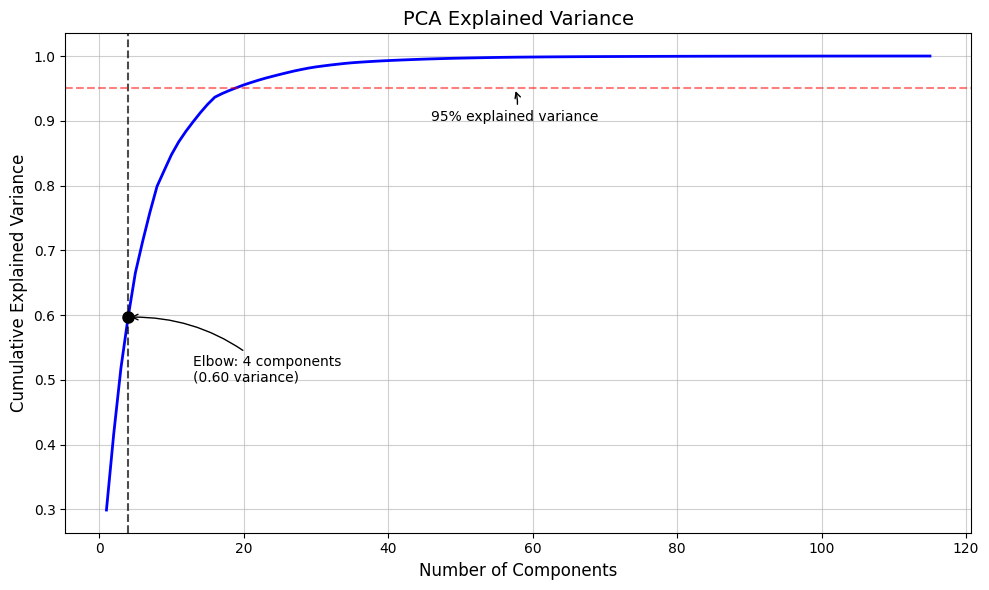

Number of components needed for 95% variance: 19
Elbow point occurs at 4 components


In [75]:
variance_info = plot_pca_explained_variance(X_train_scaled, max_components=130)

print(f"Number of components needed for 95% variance: {variance_info['n_components_95']}")
if variance_info['elbow_point']:
    print(f"Elbow point occurs at {variance_info['elbow_point']} components")


In [76]:
N_PC = 20

In [77]:
models = {
    'Linear Regression': LinearRegression(),

    # Regularized regression models
    'Ridge': Ridge(alpha=10.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=5000),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42, max_iter=5000),


    'Linear Regression with PCA': Pipeline([
        ('pca', PCA(n_components=N_PC, random_state=42)),
        ('linear', LinearRegression())
    ]),

    'Ridge with PCA': Pipeline([
        ('pca', PCA(n_components=N_PC, random_state=42)),
        ('ridge', Ridge(alpha=10.0, random_state=42))
    ]),

    'Lasso with PCA': Pipeline([
        ('pca', PCA(n_components=N_PC, random_state=42)),
        ('lasso', Lasso(alpha=0.1, random_state=42, max_iter=5000))
    ]),

    'Elastic Net with PCA': Pipeline([
        ('pca', PCA(n_components=N_PC, random_state=42)),
        ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42, max_iter=5000))
    ]),

    # SVM Regression - using linear kernel for large datasets
    #'SVM Regression': SVR(kernel='linear', C=1.0, epsilon=0.1),

    # Dimensionality reduction models
    'Principal Component Regression': Pipeline([
        ('pca', PCA(n_components=N_PC, random_state=42)),
        ('ridge', Ridge(alpha=10.0, random_state=42))
    ]),

    'Partial Least Squares': PLSRegression(n_components=N_PC, scale=False),

    'Polynomial Regression': Pipeline([
        ('pca', PCA(n_components=N_PC, random_state=42)),
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('ridge', Ridge(alpha=10.0, random_state=42))
    ]),


    # Tree-based models
    #'Random Forest': RandomForestRegressor(
    #    n_estimators=N_PC,
    #    max_depth=3,
    #    min_samples_leaf=500,
    #    max_features='sqrt',
    #    bootstrap=True,
     #   random_state=42,
    #    n_jobs=-1
    #),

    #'Gradient Boosting': GradientBoostingRegressor(
    #    n_estimators=N_PC,
    #    max_depth=3,
    #    learning_rate=0.1,
    #    subsample=0.8,
    #    min_samples_leaf=500,
    #    random_state=42
    #)

}

In [78]:
print(f"\nStarting model training and evaluation...\n")

model_results = {}

for name in tqdm(list(models.keys()), desc="Models"):
    model = models[name]

    # Special handling for PLS which has different predict behavior
    if name == 'Partial Least Squares':
        model_results[name] = evaluate_model_pls(
            model, name,
            X_train_scaled[predictor_vars], y_train,
            X_valid_scaled[predictor_vars], y_valid,
            X_test_scaled[predictor_vars], y_test
        )
    else:
        model_results[name] = evaluate_model(
            model, name,
            X_train_scaled[predictor_vars], y_train,
            X_valid_scaled[predictor_vars], y_valid,
            X_test_scaled[predictor_vars], y_test
        )


Starting model training and evaluation...



Models:   0%|          | 0/11 [00:00<?, ?it/s]

---Linear Regression Evaluation---

Training...
Training completed in 2.56 seconds

Generating predictions...
Prediction completed in 0.10 seconds

Calculating metrics...
Train R² OOS: 1.00 
Validation R² OOS: 0.99 
Test R² OOS: 0.96
              


Models:   9%|▉         | 1/11 [00:04<00:46,  4.61s/it]

---Ridge Evaluation---

Training...


Models:  18%|█▊        | 2/11 [00:05<00:22,  2.50s/it]

Training completed in 0.36 seconds

Generating predictions...
Prediction completed in 0.08 seconds

Calculating metrics...
Train R² OOS: 0.98 
Validation R² OOS: 0.97 
Test R² OOS: 0.93
              
---Lasso Evaluation---

Training...


Models:  27%|██▋       | 3/11 [00:07<00:15,  2.00s/it]

Training completed in 0.70 seconds

Generating predictions...
Prediction completed in 0.08 seconds

Calculating metrics...
Train R² OOS: 0.78 
Validation R² OOS: 0.76 
Test R² OOS: 0.71
              
---Elastic Net Evaluation---

Training...


Models:  36%|███▋      | 4/11 [00:08<00:12,  1.73s/it]

Training completed in 0.63 seconds

Generating predictions...
Prediction completed in 0.08 seconds

Calculating metrics...
Train R² OOS: 0.11 
Validation R² OOS: 0.10 
Test R² OOS: 0.05
              
---Linear Regression with PCA Evaluation---

Training...
Training completed in 0.39 seconds

Generating predictions...


Models:  45%|████▌     | 5/11 [00:09<00:09,  1.55s/it]

Prediction completed in 0.20 seconds

Calculating metrics...
Train R² OOS: 0.12 
Validation R² OOS: 0.10 
Test R² OOS: 0.05
              
---Ridge with PCA Evaluation---

Training...
Training completed in 0.24 seconds

Generating predictions...


Models:  55%|█████▍    | 6/11 [00:10<00:06,  1.38s/it]

Prediction completed in 0.18 seconds

Calculating metrics...
Train R² OOS: 0.12 
Validation R² OOS: 0.10 
Test R² OOS: 0.05
              
---Lasso with PCA Evaluation---

Training...
Training completed in 0.27 seconds

Generating predictions...


Models:  64%|██████▎   | 7/11 [00:11<00:05,  1.28s/it]

Prediction completed in 0.16 seconds

Calculating metrics...
Train R² OOS: 0.12 
Validation R² OOS: 0.10 
Test R² OOS: 0.05
              
---Elastic Net with PCA Evaluation---

Training...
Training completed in 0.27 seconds

Generating predictions...


Models:  73%|███████▎  | 8/11 [00:12<00:03,  1.22s/it]

Prediction completed in 0.20 seconds

Calculating metrics...
Train R² OOS: 0.10 
Validation R² OOS: 0.08 
Test R² OOS: 0.04
              
---Principal Component Regression Evaluation---

Training...
Training completed in 0.24 seconds

Generating predictions...


Models:  82%|████████▏ | 9/11 [00:13<00:02,  1.17s/it]

Prediction completed in 0.16 seconds

Calculating metrics...
Train R² OOS: 0.12 
Validation R² OOS: 0.10 
Test R² OOS: 0.05
              
Training PLS...
Training completed in 5.92 seconds
Generating predictions...


Models:  91%|█████████ | 10/11 [00:21<00:03,  3.05s/it]

Prediction completed in 0.78 seconds
Calculating metrics...
Train R² OOS: 0.85
Validation R² OOS: 0.86
Test R² OOS: 0.84
---Polynomial Regression Evaluation---

Training...
Training completed in 1.44 seconds

Generating predictions...


Models: 100%|██████████| 11/11 [00:25<00:00,  2.33s/it]

Prediction completed in 1.77 seconds

Calculating metrics...
Train R² OOS: 0.18 
Validation R² OOS: 0.15 
Test R² OOS: 0.08
              


In [79]:
print("\nModel Comparison (Test R² OOS):")
print(f'CAPM: {r_squared_capm:.3f}')
for name, results in model_results.items():
    print(f"{name}:\n test:{results['test_r2_oos']:.3f} train:{results['train_r2_oos']:.3f} val:{results['valid_r2_oos']:.3f}")


Model Comparison (Test R² OOS):
CAPM: 0.073
Linear Regression:
 test:0.958 train:1.000 val:0.994
Ridge:
 test:0.934 train:0.984 val:0.974
Lasso:
 test:0.712 train:0.777 val:0.757
Elastic Net:
 test:0.051 train:0.114 val:0.098
Linear Regression with PCA:
 test:0.049 train:0.122 val:0.101
Ridge with PCA:
 test:0.049 train:0.122 val:0.101
Lasso with PCA:
 test:0.049 train:0.117 val:0.098
Elastic Net with PCA:
 test:0.040 train:0.103 val:0.084
Principal Component Regression:
 test:0.049 train:0.122 val:0.101
Partial Least Squares:
 test:0.838 train:0.847 val:0.856
Polynomial Regression:
 test:0.083 train:0.184 val:0.148


In [80]:
def plot_overfitting_assessment(model_results, r_squared_capm):
    """
    Create a visualization to detect overfitting by comparing R² across training, validation and test sets
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract model names and R² values
    model_names = ['CAPM'] + list(model_results.keys())
    train_r2 = [np.nan]  # CAPM doesn't have train R²
    valid_r2 = [np.nan]  # CAPM doesn't have validation R²
    test_r2 = [r_squared_capm]

    for name, results in model_results.items():
        train_r2.append(results['train_r2_oos'])
        valid_r2.append(results['valid_r2_oos'])
        test_r2.append(results['test_r2_oos'])

    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Set width of bars
    bar_width = 0.25

    # Set position of bars on x axis
    r1 = np.arange(len(model_names))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Create bars
    train_bars = ax.bar(r1, train_r2, width=bar_width, label='Train', color='skyblue', alpha=0.8)
    valid_bars = ax.bar(r2, valid_r2, width=bar_width, label='Validation', color='lightgreen', alpha=0.8)
    test_bars = ax.bar(r3, test_r2, width=bar_width, label='Test', color='salmon', alpha=0.8)

    # Add labels and title
    ax.set_xlabel('Models', fontweight='bold', fontsize=12)
    ax.set_ylabel('R² OOS', fontweight='bold', fontsize=12)
    ax.set_title('Model Performance Comparison Across Datasets', fontweight='bold', fontsize=14)
    ax.set_xticks([r + bar_width for r in range(len(model_names))])
    ax.set_xticklabels(model_names, rotation=45, ha='right')

    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Add legend
    ax.legend()

    # Add a grid
    ax.grid(True, linestyle='--', alpha=0.3)

    # Use red color for bars when there's a significant train-test gap
    overfitting_threshold = 0.15  # Adjust as needed

    for i in range(1, len(model_names)):  # Skip CAPM
        if train_r2[i] is not None and test_r2[i] is not None:
            gap = train_r2[i] - test_r2[i]

            # Add gap text above the bars without arrows or "Potential overfitting" text
            if gap > 0:
                ax.text(r1[i] + bar_width, max(train_r2[i], valid_r2[i] if valid_r2[i] is not None else 0) + 0.02,
                       f'Gap: {gap:.2f}', ha='center', fontsize=9,
                       color='red' if gap > overfitting_threshold else 'blue')


    plt.tight_layout()
    return fig

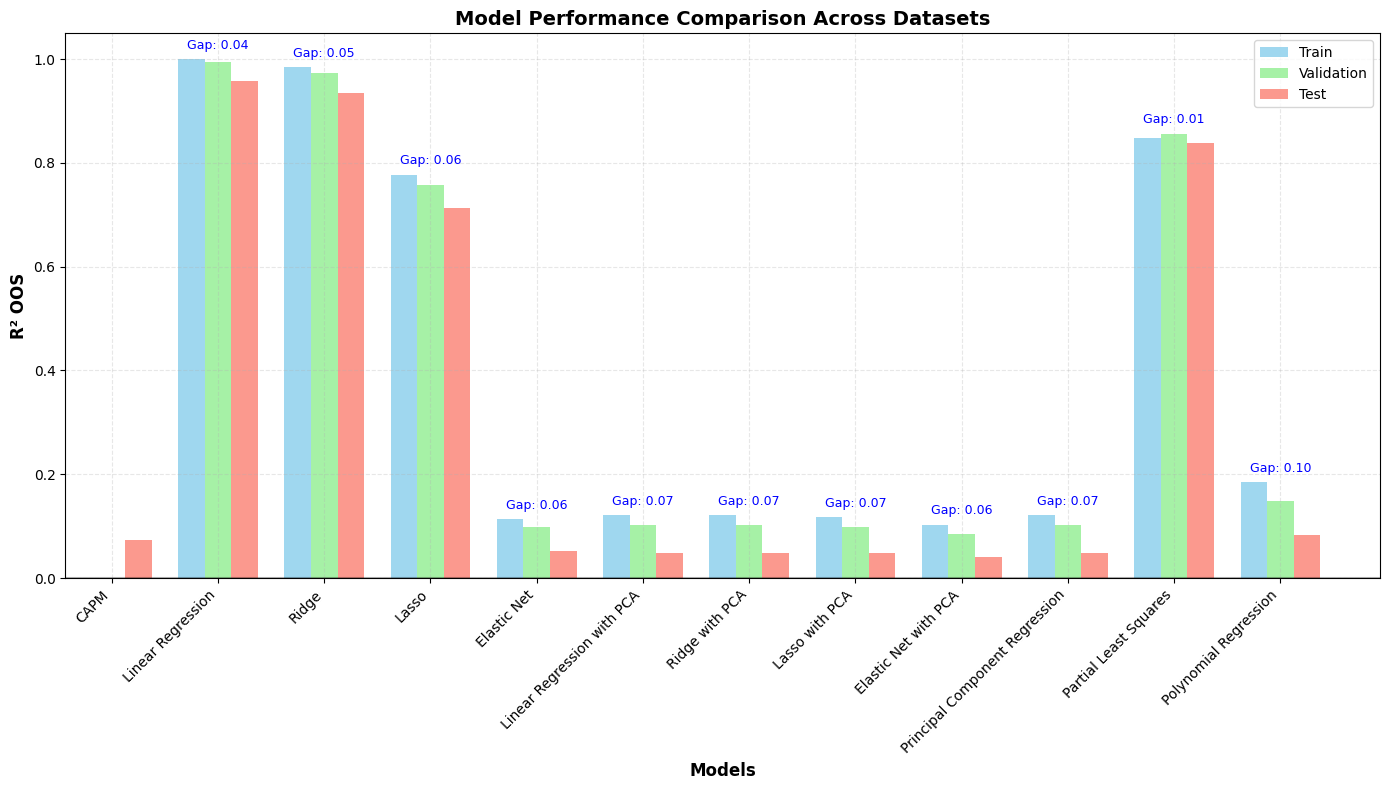

In [81]:
fig2 = plot_overfitting_assessment(model_results, r_squared_capm)
plt.show()

In [82]:
import math

def plot_model_comparison(model_results, merged_df_capm, test_indices, y_test):
    # Determine the grid layout based on number of models
    num_models = len(model_results)
    cols = min(3, num_models)  # Maximum 3 columns
    rows = math.ceil(num_models / cols)

    # Create the figure and subplots
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)

    # Flatten axs if it's a multi-dimensional array
    if rows > 1 or cols > 1:
        axs = axs.flatten()
    else:
        axs = [axs]  # Convert to list if there's only one subplot

    # Get test data for CAPM
    test_data = merged_df_capm.loc[test_indices]

    # Plot each model in its own subplot
    for i, (name, results) in enumerate(model_results.items()):
        model_pred = results['test_pred']

        # Plot model prediction also with reduced transparency
        axs[i].scatter(model_pred, y_test,
                    alpha=0.15,  # Higher alpha to stand out against CAPM
                    color='green',
                    label=name)


        # Plot CAPM prediction with reduced transparency
        axs[i].scatter(test_data['CAPM_Predicted_ExcessReturn'],
                    test_data['ExcessReturn'],
                    alpha=0.05,  # Reduced transparency for better visibility
                    color='blue',
                    label='CAPM')


        # Add subplot title and labels
        axs[i].set_title(f'{name} vs CAPM')
        axs[i].set_xlabel('Predicted Excess Return')
        axs[i].set_ylabel('Actual Excess Return')
        axs[i].grid(True, alpha=0.2)
        axs[i].legend()

        # Add performance metrics as text
        metrics_text = (
            f"{name} R² OOS: {results['test_r2_oos']:.4f}\n"
            f"CAPM R² OOS: {r_squared_capm:.4f}"
        )
        axs[i].text(0.05, 0.95, metrics_text,
                transform=axs[i].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide any unused subplots
    for j in range(num_models, len(axs)):
        axs[j].set_visible(False)

    # Add general title to the entire figure
    plt.suptitle('Comparison of Machine Learning Models vs CAPM Benchmark',
                fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    fig.subplots_adjust(top=0.93)  # Make room for the suptitle

    plt.show()


/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_7837/811107011.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


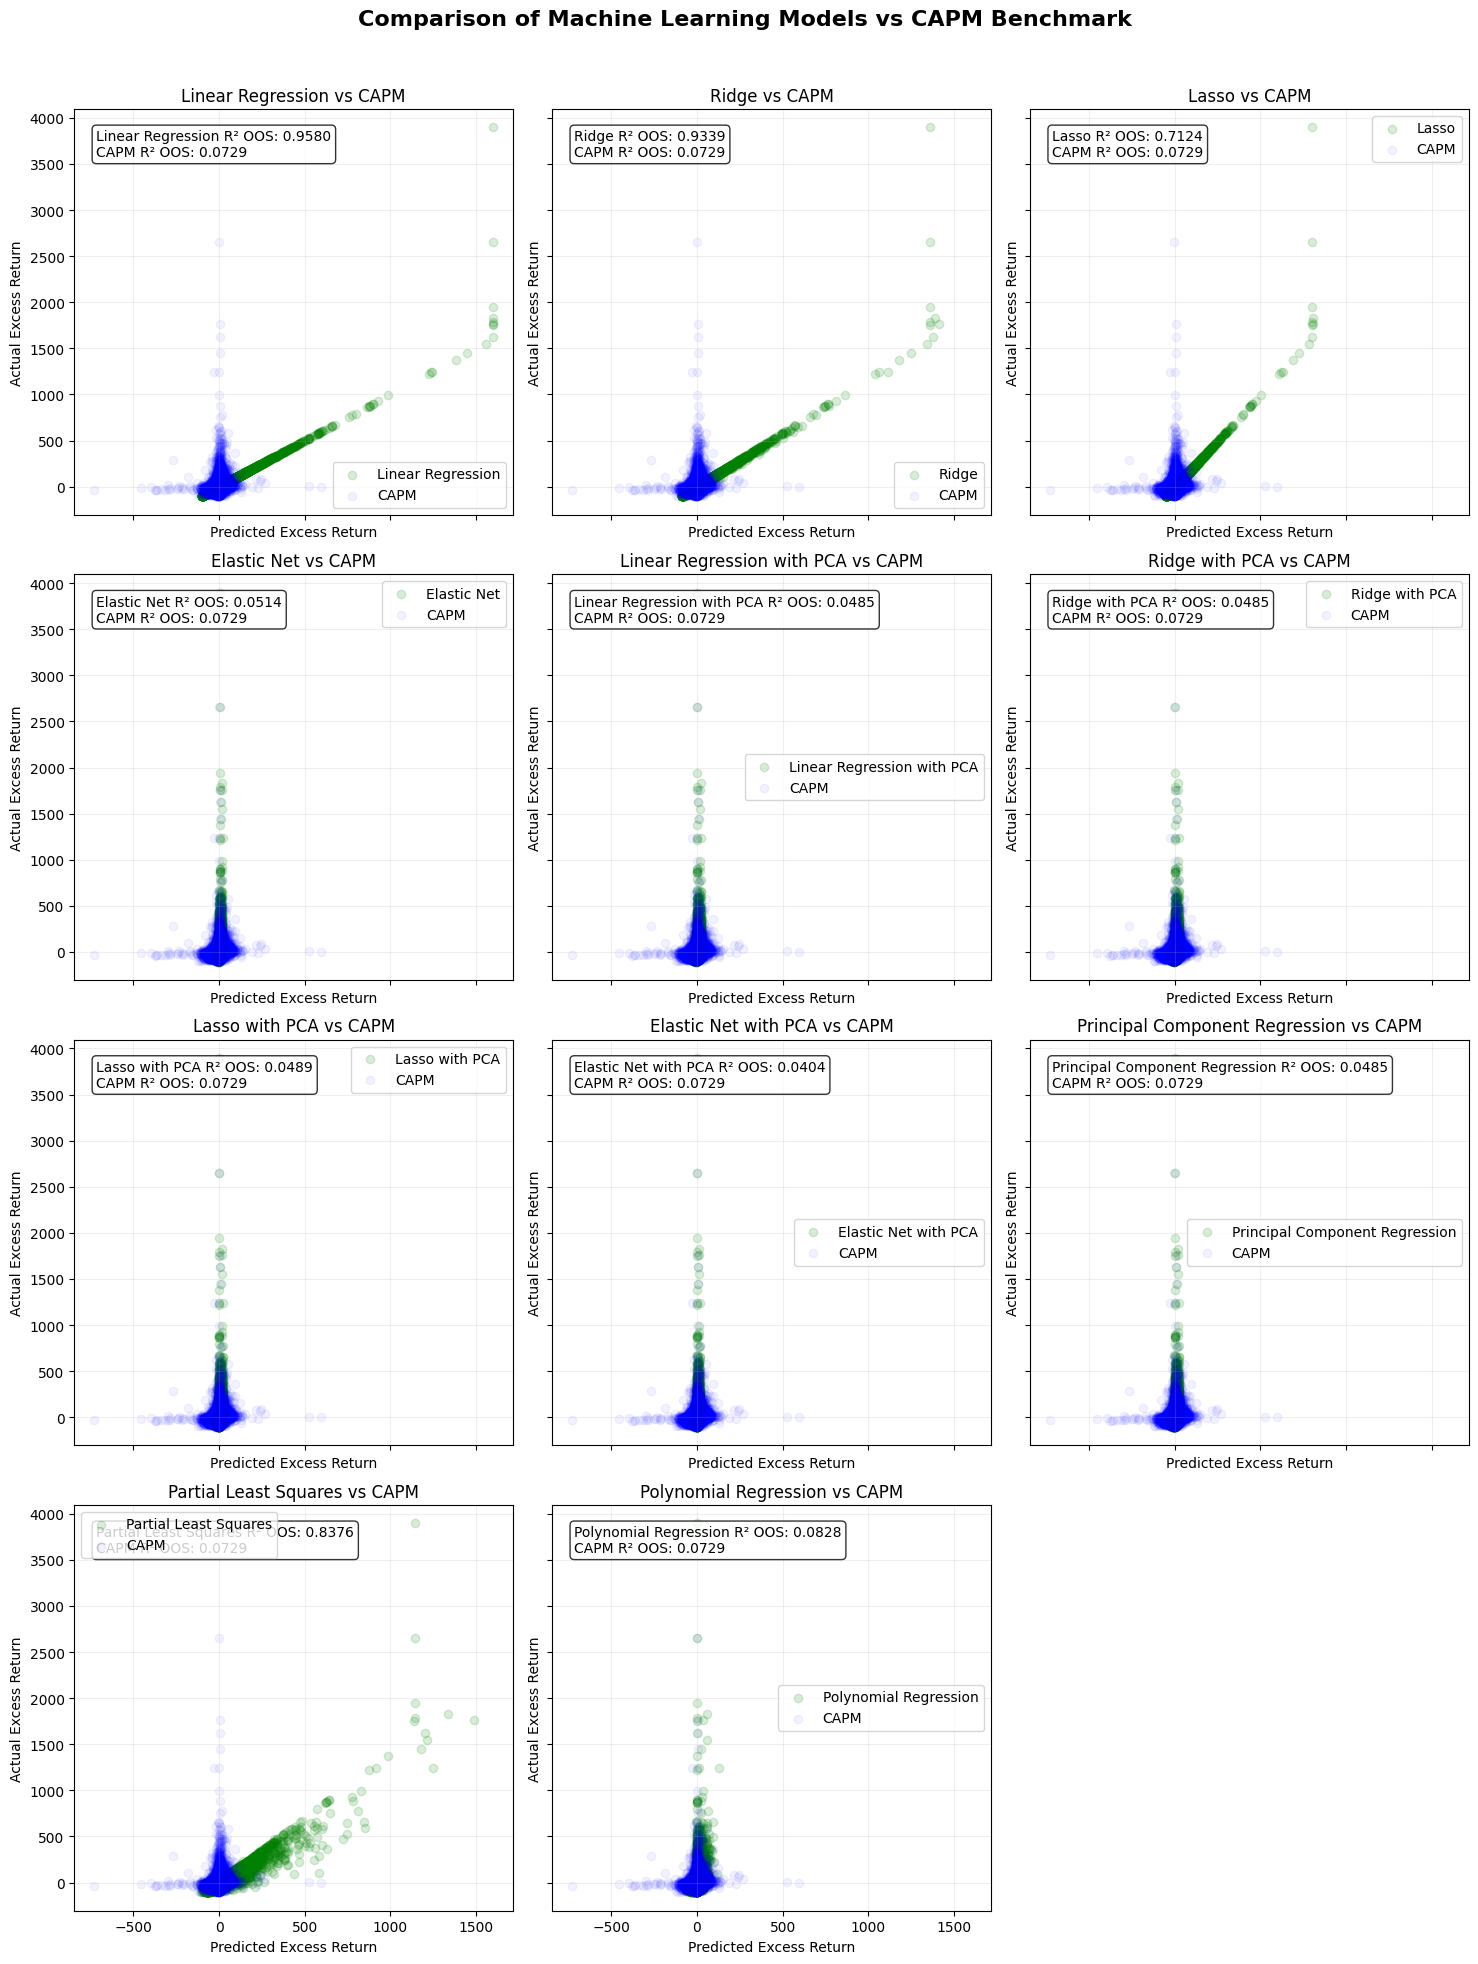

In [83]:
plot_model_comparison(model_results, merged_df_capm, test_indices, y_test)

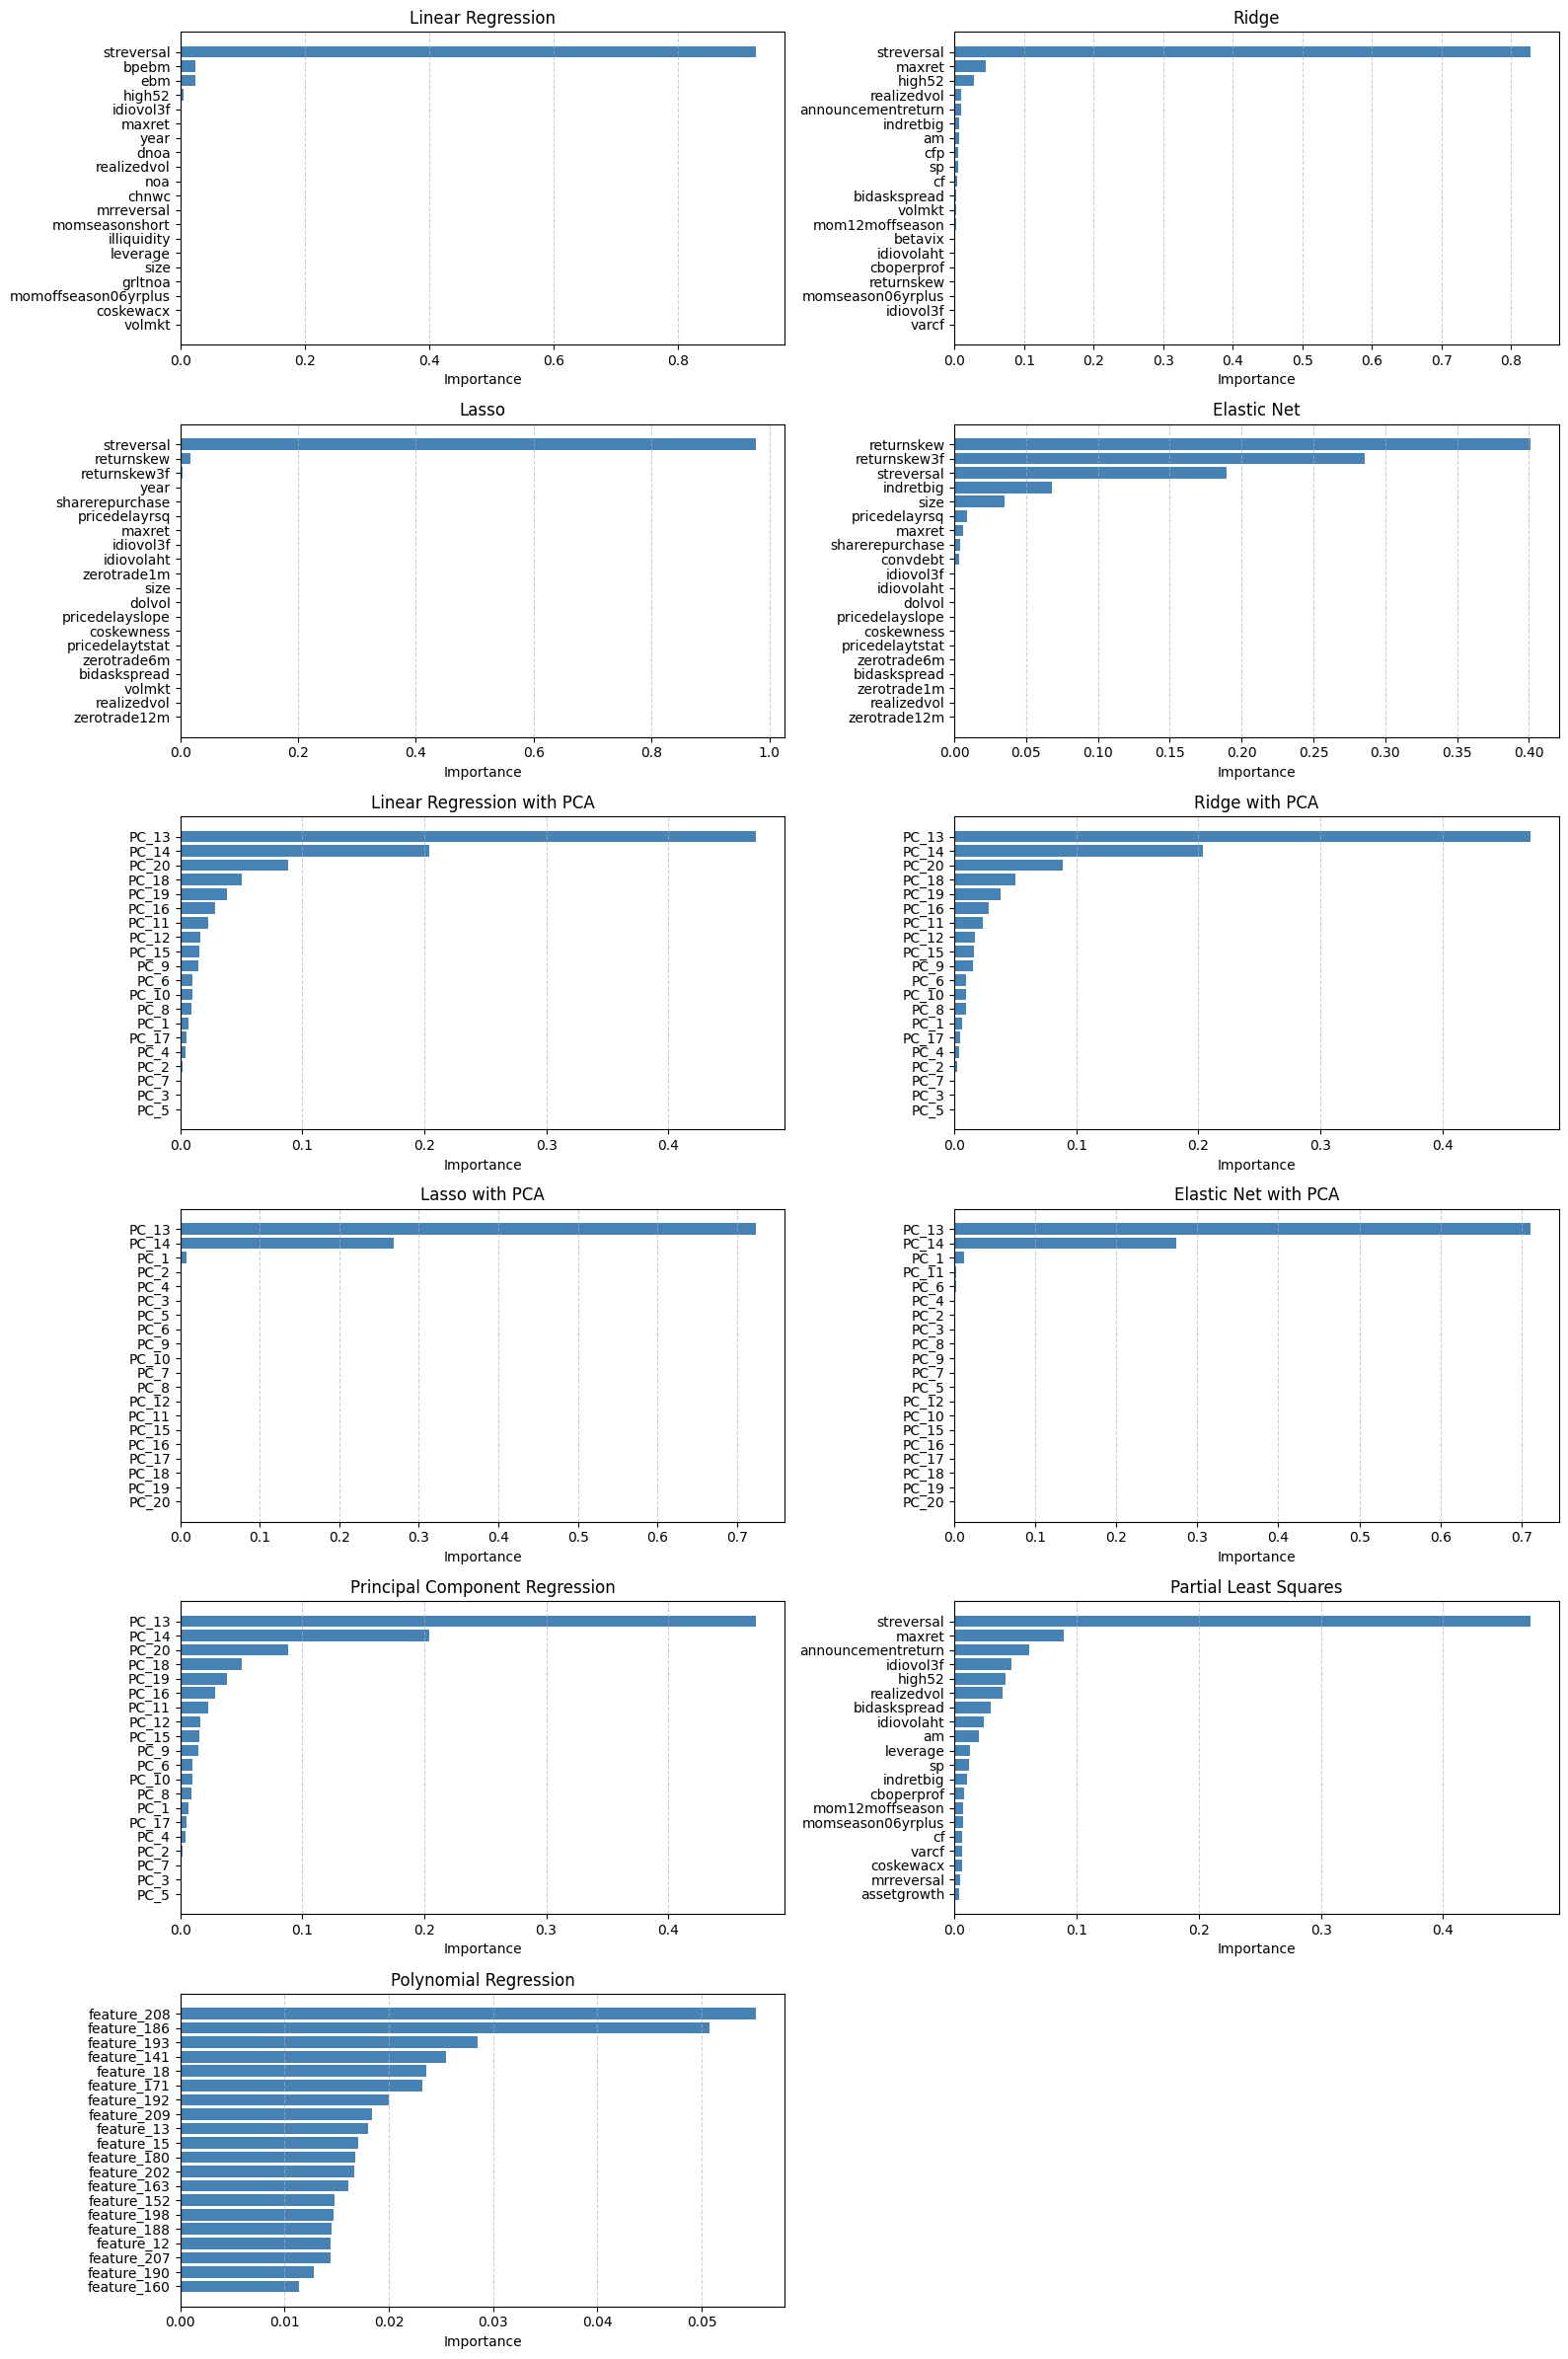

In [84]:
fig = plot_feature_importance(
    model_results=model_results,
    models=models,
    X_train=X_train_scaled[predictor_vars],
    y_train=y_train,
    feature_names=predictor_vars if isinstance(X_train_scaled, pd.DataFrame) else [f'feature_{i}' for i in range(X_train_scaled.shape[1])],
    n_features=20,
    ncols=2,
    figsize=(16, 24)
)

plt.show()

# Tuning

In [85]:
def tune_model_params(model_name, X_train, y_train, X_valid, y_valid, param_grid):
    """
    Tune hyperparameters for a given model using validation data with focus on r2_oos

    Parameters:
    -----------
    model_name : str
        Name of the model to tune
    X_train : array
        Training feature data (already scaled)
    y_train : array
        Training target data
    X_valid : array
        Validation feature data (already scaled)
    y_valid : array
        Validation target data
    param_grid : dict
        Dictionary of parameter grid to search

    Returns:
    --------
    dict
        Best parameters and model
    """
    best_val_r2 = -np.inf  # We want to maximize R² OOS
    best_params = None
    best_model = None

    # Convert param_grid to list of parameter combinations
    grid = list(ParameterGrid(param_grid))

    # Define function to evaluate a parameter set
    def evaluate_params(params):
        # Create model based on name with specific parameters
        try:
            if model_name == 'Linear Regression':
                # Linear regression doesn't have parameters to tune
                model = LinearRegression()

            elif model_name == 'Ridge':
                model = Ridge(alpha=params['alpha'], random_state=42)

            elif model_name == 'Lasso':
                model = Lasso(alpha=params['alpha'], max_iter=10000, random_state=42)

            elif model_name == 'Elastic Net':
                model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'],
                                  max_iter=10000, random_state=42)

            # PCA Pipeline models
            elif model_name == 'Linear Regression with PCA':
                model = Pipeline([
                    ('pca', PCA(n_components=params['pca__n_components'], random_state=42)),
                    ('linear', LinearRegression())
                ])

            elif model_name == 'Ridge with PCA':
                model = Pipeline([
                    ('pca', PCA(n_components=params['pca__n_components'], random_state=42)),
                    ('ridge', Ridge(alpha=params['ridge__alpha'], random_state=42))
                ])

            elif model_name == 'Lasso with PCA':
                model = Pipeline([
                    ('pca', PCA(n_components=params['pca__n_components'], random_state=42)),
                    ('lasso', Lasso(alpha=params['lasso__alpha'], max_iter=10000, random_state=42))
                ])

            elif model_name == 'Elastic Net with PCA':
                model = Pipeline([
                    ('pca', PCA(n_components=params['pca__n_components'], random_state=42)),
                    ('elasticnet', ElasticNet(alpha=params['elasticnet__alpha'],
                                            l1_ratio=params['elasticnet__l1_ratio'],
                                            max_iter=10000, random_state=42))
                ])

            elif model_name == 'Principal Component Regression':
                model = Pipeline([
                    ('pca', PCA(n_components=params['pca__n_components'], random_state=42)),
                    ('ridge', Ridge(alpha=params['ridge__alpha'], random_state=42))
                ])

            elif model_name == 'Partial Least Squares':
                model = PLSRegression(n_components=params['n_components'], scale=False)

            elif model_name == 'Polynomial Regression':
                model = Pipeline([
                    ('pca', PCA(n_components=params['pca__n_components'], random_state=42)),
                    ('poly', PolynomialFeatures(degree=params['poly__degree'],
                                               interaction_only=True, include_bias=False)),
                    ('ridge', Ridge(alpha=params['ridge__alpha'], random_state=42))
                ])

            elif model_name == 'Random Forest':
                model = RandomForestRegressor(
                    n_estimators=params['n_estimators'],
                    max_depth=params['max_depth'],
                    min_samples_leaf=params['min_samples_leaf'],
                    max_features=params['max_features'],
                    bootstrap=True,
                    random_state=42,
                    n_jobs=-1
                )

            elif model_name == 'Gradient Boosting':
                model = GradientBoostingRegressor(
                    n_estimators=params['n_estimators'],
                    max_depth=params['max_depth'],
                    learning_rate=params['learning_rate'],
                    subsample=params['subsample'],
                    min_samples_leaf=params['min_samples_leaf'],
                    random_state=42
                )

            else:
                print(f"Unknown model: {model_name}")
                return -np.inf, params, None

            # Fit the model
            # model.fit(X_train, y_train)

            if isinstance(X_train, pd.DataFrame):
                model.fit(X_train, y_train)
                valid_preds = model.predict(X_valid)
            else:
                model.fit(X_train, y_train)
                valid_preds = model.predict(X_valid)


            # Make validation predictions
            valid_preds = model.predict(X_valid)

            # Flatten predictions if needed
            if hasattr(valid_preds, 'shape') and len(valid_preds.shape) > 1:
                valid_preds = valid_preds.flatten()

            # Calculate custom R² OOS metric
            r2_value = r2_oos(y_valid, valid_preds)

            return r2_value, params, model

        except Exception as e:
            print(f"Error with {model_name}, params: {params}. Error: {e}")
            return -np.inf, params, None

    # Evaluate all parameter combinations in parallel
    results = Parallel(n_jobs=3)(delayed(evaluate_params)(params) for params in grid)

    # Find the best parameters (highest R² OOS)
    for r2_value, params, model in results:
        if r2_value > best_val_r2:
            best_val_r2 = r2_value
            best_params = params
            best_model = model

    return {
        'best_params': best_params,
        'best_model': best_model,
        'best_val_r2': best_val_r2
    }

In [86]:
# Define parameter grids for each model with adjusted hyperparameters to reduce overfitting
param_grids = {
    'Linear Regression': {},  # No parameters to tune

    'Ridge': {
        'alpha': [0.1, 1.0, 10.0, 50.0, 100.0, 200.0]  # Expanded alpha range
    },

    'Lasso': {
        'alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]  # Expanded alpha range
    },

    'Elastic Net': {
        'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],  # Higher alpha values
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    },

    'Linear Regression with PCA': {
        'pca__n_components': [5, 10, 15, 20]  # Reduced from N_PC to prevent overfitting
    },

    'Ridge with PCA': {
        'pca__n_components': [5, 10, 15, 20],  # Reduced components
        'ridge__alpha': [1.0, 10.0, 50.0, 100.0]  # Higher regularization
    },

    'Lasso with PCA': {
        'pca__n_components': [5, 10, 15, 20],
        'lasso__alpha': [0.1, 0.5, 1.0, 5.0]
    },

    'Elastic Net with PCA': {
        'pca__n_components': [5, 10, 15, 20],
        'elasticnet__alpha': [0.5, 1.0, 5.0, 10.0],
        'elasticnet__l1_ratio': [0.3, 0.5, 0.7]
    },

    'Principal Component Regression': {
        'pca__n_components': [5, 10, 15, 20],  # Reduced components
        'ridge__alpha': [1.0, 10.0, 50.0, 100.0]
    },

    'Partial Least Squares': {
        'n_components': [2, 5, 8, 10, 15]  # Your current PLS is working well
    },

    'Polynomial Regression': {
        'pca__n_components': [5, 8, 10, 15],  # Reduced components
        'poly__degree': [1, 2],  # Consider lower degree
        'ridge__alpha': [10.0, 50.0, 100.0, 200.0]  # Stronger regularization
    }#,

    #'Random Forest': {
    #    'n_estimators': [10, 15, 20, 25],
    #    'max_depth': [2, 3, 5],  # Consider even limiting to max_depth=2
    #    'min_samples_leaf': [500, 1000, 2000],  # Increased to prevent overfitting
    #    'max_features': ['sqrt', 'log2', 0.3]  # Add feature subsampling options
    #},

    #'Gradient Boosting': {
    #    'n_estimators': [50, 100, 200],
    #    'max_depth': [1, 2, 3],  # Shallower trees
    #    'learning_rate': [0.01, 0.05, 0.1],  # Consider even smaller learning rates
    #    'subsample': [0.5, 0.7, 0.8],  # More aggressive subsampling
    #    'min_samples_leaf': [500, 1000, 2000]  # Larger leaf size
    #}
}

In [93]:
def tune_and_evaluate_all_models(X_train, y_train, X_valid, y_valid, X_test, y_test,
                                capm_pred_test=None):
    """
    Train and evaluate all models with tuned parameters

    Returns:
    --------
    dict
        Dictionary with tuned models and performance metrics
    """
    models_dict = {}
    performance = {}

    for model_name in tqdm(param_grids.keys(), desc="Tuning models"):
        print(f"\nTuning {model_name}...")

        # Skip models that are too computationally expensive
        if model_name == 'SVM Regression' and X_train.shape[0] > 10000:
            print(f"Skipping {model_name} due to large dataset size")
            continue

        # Get parameter grid for the model
        param_grid = param_grids[model_name]

        result = tune_model_params(model_name, X_train, y_train, X_valid, y_valid, param_grid)

        best_params = result['best_params']
        best_val_r2 = result.get('best_val_r2', None)

        if best_params is None:
            print(f"Failed to tune {model_name}")
            continue

        # Retrain on combined train+valid data
        X_train_valid = np.vstack([X_train, X_valid])
        y_train_valid = np.concatenate([y_train, y_valid])

        # Create a new model with the best parameters instead of reusing the trained one
        try:
            if model_name == 'Linear Regression':
                final_model = LinearRegression()

            elif model_name == 'Ridge':
                final_model = Ridge(alpha=best_params['alpha'], random_state=42)

            elif model_name == 'Lasso':
                final_model = Lasso(alpha=best_params['alpha'], max_iter=10000, random_state=42)

            elif model_name == 'Elastic Net':
                final_model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'],
                                        max_iter=10000, random_state=42)

            # PCA Pipeline models
            elif model_name == 'Linear Regression with PCA':
                final_model = Pipeline([
                    ('pca', PCA(n_components=best_params['pca__n_components'], random_state=42)),
                    ('linear', LinearRegression())
                ])

            elif model_name == 'Ridge with PCA':
                final_model = Pipeline([
                    ('pca', PCA(n_components=best_params['pca__n_components'], random_state=42)),
                    ('ridge', Ridge(alpha=best_params['ridge__alpha'], random_state=42))
                ])

            elif model_name == 'Lasso with PCA':
                final_model = Pipeline([
                    ('pca', PCA(n_components=best_params['pca__n_components'], random_state=42)),
                    ('lasso', Lasso(alpha=best_params['lasso__alpha'], max_iter=10000, random_state=42))
                ])

            elif model_name == 'Elastic Net with PCA':
                final_model = Pipeline([
                    ('pca', PCA(n_components=best_params['pca__n_components'], random_state=42)),
                    ('elasticnet', ElasticNet(alpha=best_params['elasticnet__alpha'],
                                            l1_ratio=best_params['elasticnet__l1_ratio'],
                                            max_iter=10000, random_state=42))
                ])

            elif model_name == 'Principal Component Regression':
                final_model = Pipeline([
                    ('pca', PCA(n_components=best_params['pca__n_components'], random_state=42)),
                    ('ridge', Ridge(alpha=best_params['ridge__alpha'], random_state=42))
                ])

            elif model_name == 'Partial Least Squares':
                final_model = PLSRegression(n_components=best_params['n_components'], scale=False)

            elif model_name == 'Polynomial Regression':
                final_model = Pipeline([
                    ('pca', PCA(n_components=best_params['pca__n_components'], random_state=42)),
                    ('poly', PolynomialFeatures(degree=best_params['poly__degree'],
                                               interaction_only=True, include_bias=False)),
                    ('ridge', Ridge(alpha=best_params['ridge__alpha'], random_state=42))
                ])

            elif model_name == 'Random Forest':
                final_model = RandomForestRegressor(
                    n_estimators=best_params['n_estimators'],
                    max_depth=best_params['max_depth'],
                    min_samples_leaf=best_params['min_samples_leaf'],
                    max_features=best_params['max_features'],
                    bootstrap=True,
                    random_state=42,
                    n_jobs=-1
                )

            elif model_name == 'Gradient Boosting':
                final_model = GradientBoostingRegressor(
                    n_estimators=best_params['n_estimators'],
                    max_depth=best_params['max_depth'],
                    learning_rate=best_params['learning_rate'],
                    subsample=best_params['subsample'],
                    min_samples_leaf=best_params['min_samples_leaf'],
                    random_state=42
                )

            else:
                print(f"Unknown model: {model_name}")
                continue


            final_model.fit(X_train_valid, y_train_valid)

        except Exception as e:
            print(f"Error creating model with best parameters: {e}")
            continue


        train_preds = final_model.predict(X_train)
        valid_preds = final_model.predict(X_valid)
        test_preds = final_model.predict(X_test)

        # Flatten predictions if needed
        if hasattr(test_preds, 'shape') and len(test_preds.shape) > 1:
            train_preds = train_preds.flatten()
            valid_preds = valid_preds.flatten()
            test_preds = test_preds.flatten()

        # Calculate R² OOS for all splits
        train_r2_oos = r2_oos(y_train, train_preds)
        valid_r2_oos = r2_oos(y_valid, valid_preds)
        test_r2_oos = r2_oos(y_test, test_preds)

        # Calculate MSE
        test_mse = mean_squared_error(y_test, test_preds)

        # Calculate R² against CAPM if provided
        r2_vs_capm = None
        if capm_pred_test is not None:
            capm_mse = mean_squared_error(y_test, capm_pred_test)
            r2_vs_capm = 1 - (test_mse / capm_mse)

        # Store results
        models_dict[model_name] = final_model
        performance[model_name] = {
            'best_params': best_params,
            'train_r2_oos': train_r2_oos,
            'valid_r2_oos': valid_r2_oos,
            'test_r2_oos': test_r2_oos,
            'best_val_r2': best_val_r2,
            'test_mse': test_mse,
            'r2_vs_capm': r2_vs_capm,
            'train_pred': train_preds,
            'valid_pred': valid_preds,
            'test_pred': test_preds
        }

        print(f"{model_name} Results:")
        print(f"  Train R² OOS: {train_r2_oos:.4f}")
        print(f"  Valid R² OOS: {valid_r2_oos:.4f}")
        print(f"  Test R² OOS: {test_r2_oos:.4f}")
        if r2_vs_capm is not None:
            print(f"  R² vs CAPM: {r2_vs_capm:.4f}")
        print(f"  Best parameters: {best_params}")

    return {
        'models': models_dict,
        'performance': performance
    }

In [88]:
# Extract only the CAPM prediction column
capm_predictions = merged_df_capm.loc[test_indices, 'CAPM_Predicted_ExcessReturn'].values


In [97]:

capm_predictions.isna().any().any()


AttributeError: 'numpy.ndarray' object has no attribute 'isna'

In [94]:
results = tune_and_evaluate_all_models(
    X_train_scaled, y_train,
    X_valid_scaled, y_valid,
    X_test_scaled, y_test,
    capm_pred_test=capm_predictions
)

Tuning models:   0%|          | 0/11 [00:00<?, ?it/s]


Tuning Linear Regression...


/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
Tuning models:   0%|          | 0/11 [00:08<?, ?it/s]


ValueError: Input contains NaN.

In [ ]:
tuned_model_results = results['performance']
tuned_model_results

{'Linear Regression': {'best_params': {},
  'train_r2_oos': np.float64(0.958136085592045),
  'valid_r2_oos': np.float64(0.9759784327596296),
  'test_r2_oos': np.float64(0.8534561048200199),
  'best_val_r2': np.float64(0.838777108447017),
  'test_mse': 23.912847666738593,
  'r2_vs_capm': 0.8283990922505781,
  'train_pred': array([ -7.49958237,  -6.11585575,  -3.43844281, ...,  -3.63824985,
         -20.77145684, -12.28437782]),
  'valid_pred': array([ -5.8510326 ,   0.46902758, -14.24818282, ...,  -4.59701542,
          -7.40100299,  -3.58037091]),
  'test_pred': array([ -6.35523162, -19.99002065,  -2.63898998, ..., -10.39458773,
           6.98795693,  -0.37202904])},
 'Ridge': {'best_params': {'alpha': 10.0},
  'train_r2_oos': np.float64(0.9578522764731797),
  'valid_r2_oos': np.float64(0.9761810457913686),
  'test_r2_oos': np.float64(0.8543228301364986),
  'best_val_r2': np.float64(0.8395184584768525),
  'test_mse': 23.77141652464697,
  'r2_vs_capm': 0.8294140158056977,
  'train_pred

In [ ]:
list(merged_df_capm.columns)

['permno',
 'date',
 'prc',
 'ret',
 'price',
 'size',
 'streversal',
 'maxret',
 'high52',
 'realizedvol',
 'idiovol3f',
 'returnskew3f',
 'returnskew',
 'idiovolaht',
 'zerotrade1m',
 'dolvol',
 'pricedelayrsq',
 'pricedelayslope',
 'coskewness',
 'pricedelaytstat',
 'zerotrade6m',
 'bidaskspread',
 'volmkt',
 'zerotrade12m',
 'beta',
 'illiquidity',
 'coskewacx',
 'divinit',
 'divomit',
 'exchswitch',
 'indipo',
 'spinoff',
 'firmage',
 'indmom',
 'mom6m',
 'volsd',
 'mom12moffseason',
 'betafp',
 'momseasonshort',
 'mom12m',
 'intmom',
 'volumetrend',
 'convdebt',
 'rdipo',
 'sharerepurchase',
 'opleverage',
 'bookleverage',
 'roe',
 'mrreversal',
 'shareiss1y',
 'hire',
 'betavix',
 'residualmomentum',
 'momseason',
 'momoffseason',
 'betaliquidityps',
 'chinv',
 'delcoa',
 'dellti',
 'assetgrowth',
 'accruals',
 'delcol',
 'chnwc',
 'delfinl',
 'delnetfin',
 'chnncoa',
 'grltnoa',
 'tax',
 'noa',
 'delequ',
 'dnoa',
 'herf',
 'pctacc',
 'totalaccruals',
 'equityduration',
 'lrrev

In [ ]:
tuned_model_results = results['performance']

print("\nModel Comparison (Test R² OOS):")
print(f'CAPM: {r_squared_capm:.3f}')
for name, results in tuned_model_results.items():
    print(f"{name}:\n test:{results['test_r2_oos']:.3f} train:{results['train_r2_oos']:.3f} val:{results['valid_r2_oos']:.3f}")


Model Comparison (Test R² OOS):
CAPM: 0.146
Linear Regression:
 test:0.853 train:0.958 val:0.976
Ridge:
 test:0.854 train:0.958 val:0.976
Lasso:
 test:0.806 train:0.929 val:0.963
Elastic Net:
 test:0.346 train:0.572 val:0.542
Linear Regression with PCA:
 test:-0.025 train:0.294 val:0.227
Ridge with PCA:
 test:-0.025 train:0.294 val:0.227
Lasso with PCA:
 test:-0.021 train:0.289 val:0.222
Elastic Net with PCA:
 test:-0.091 train:0.190 val:0.119
Principal Component Regression:
 test:-0.025 train:0.294 val:0.227
Partial Least Squares:
 test:0.852 train:0.952 val:0.970
Polynomial Regression:
 test:0.017 train:0.316 val:0.243


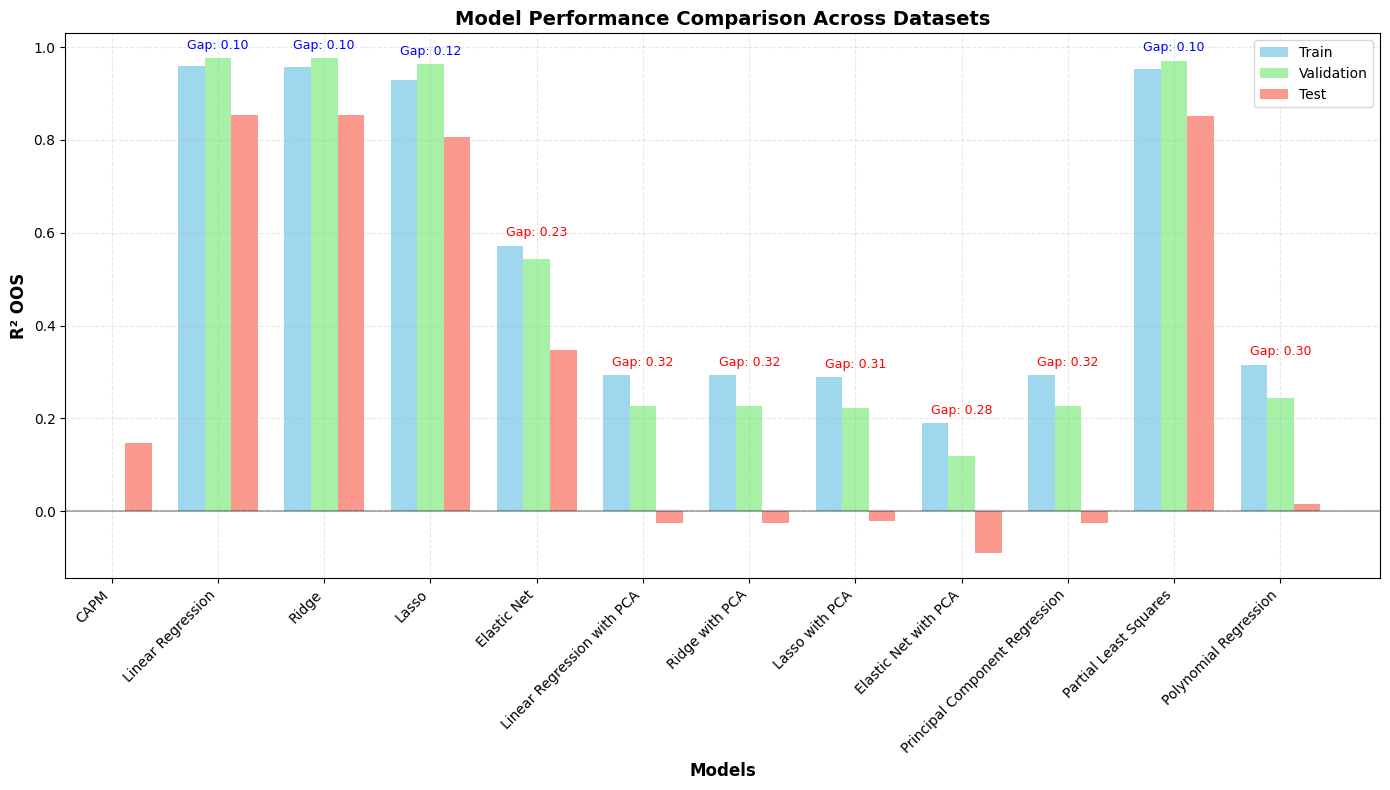

In [ ]:
fig_t = plot_overfitting_assessment(tuned_model_results, r_squared_capm)
plt.show()

/var/folders/7j/8pz9dqx16j514s66gfbnpf1r0000gn/T/ipykernel_2649/811107011.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


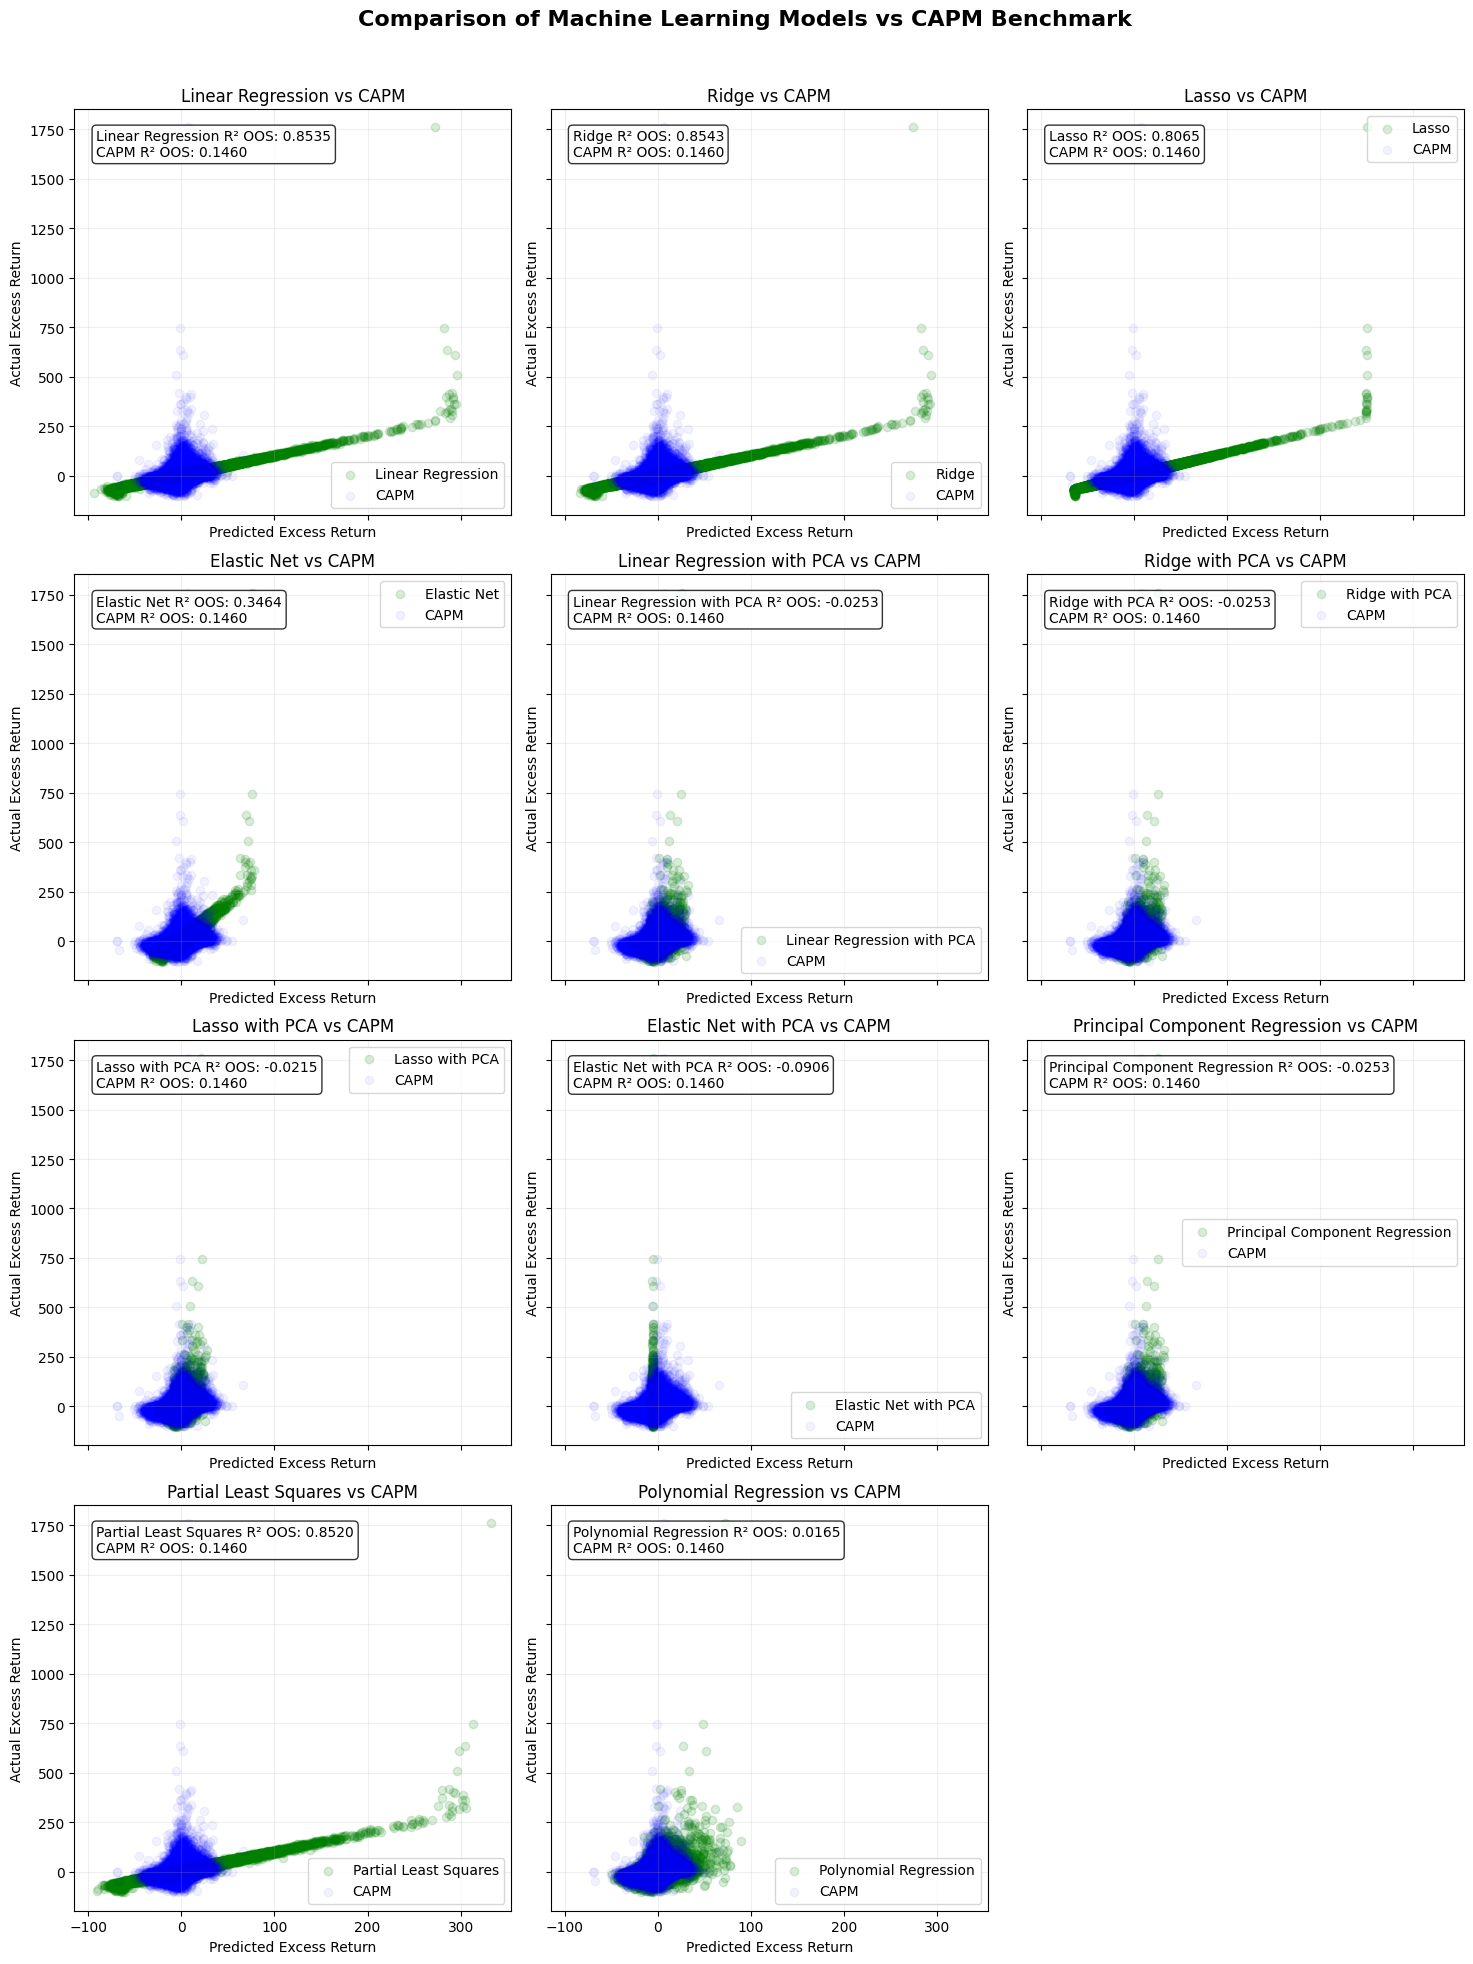

In [ ]:
plot_model_comparison(tuned_model_results, merged_df_capm, test_indices, y_test)

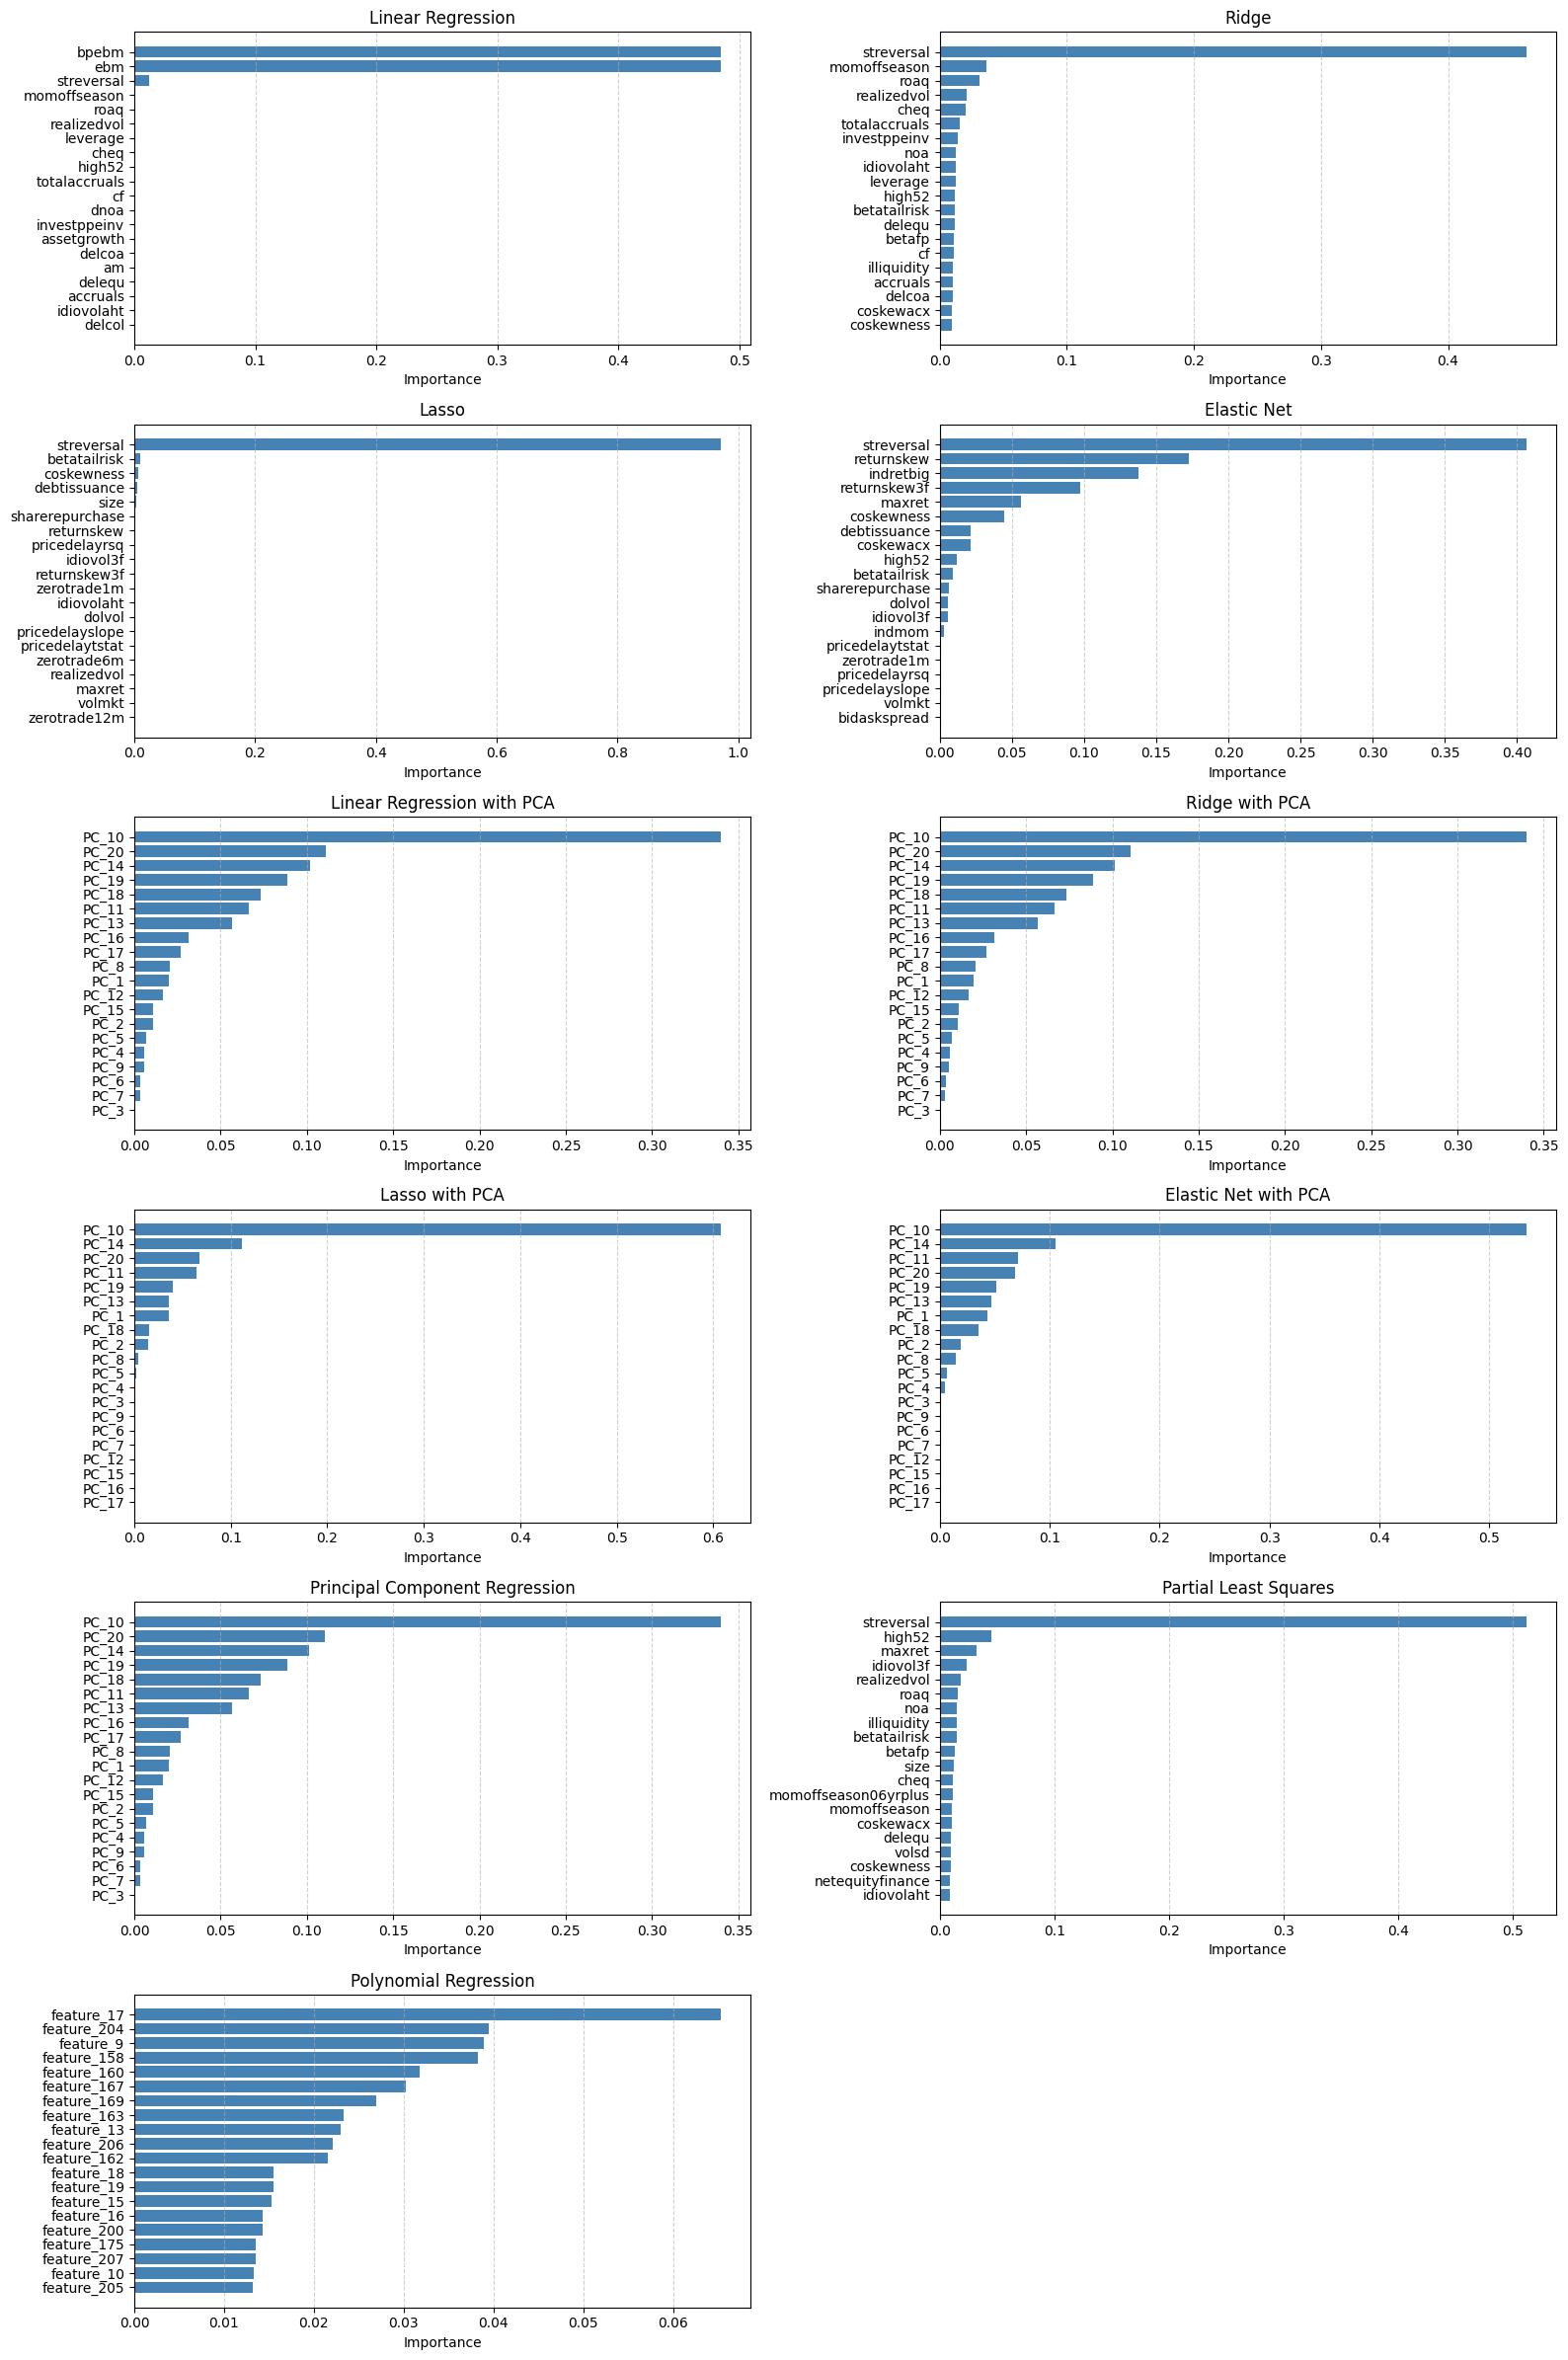

In [ ]:
fig_t2 = plot_feature_importance(
    model_results=tuned_model_results,
    models=models,
    X_train=X_train_scaled[predictor_vars],
    y_train=y_train,
    feature_names=predictor_vars if isinstance(X_train_scaled, pd.DataFrame) else [f'feature_{i}' for i in range(X_train_scaled.shape[1])],
    n_features=20,
    ncols=2,
    figsize=(16, 24)
)

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import datetime

#---------------------------------------------------------------------------------
# 1. R² COMPARISON PLOT
#---------------------------------------------------------------------------------

def create_r2_comparison_plot(tuned_model_results, r_squared_capm):
    """
    Creates a bar plot comparing the out-of-sample R² of different machine learning models.
    """
    # Extract model names and R² values
    model_names = ['CAPM'] + list(tuned_model_results.keys())

    # Extract test R² values
    test_r2 = [r_squared_capm]
    for model_name in tuned_model_results.keys():
        test_r2.append(tuned_model_results[model_name]['test_r2_oos'])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Model': model_names,
        'R² OOS': test_r2
    })

    # Set up the figure
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bar plot with a color palette
    bars = ax.bar(plot_df['Model'], plot_df['R² OOS'],
                 color=sns.color_palette("tab10", len(plot_df)))

    # Add value labels on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height < 0:
            va = 'top'
            offset = -0.01
        else:
            va = 'bottom'
            offset = 0.01

        ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'{test_r2[i]:.3f}',
                ha='center', va=va, fontsize=9)

    # Add horizontal line at 0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Set labels and title
    ax.set_ylabel('Out-of-Sample R²')
    ax.set_title('Comparison of Machine Learning Models (Test R² OOS)')

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Tight layout
    plt.tight_layout()

    return fig, ax

#---------------------------------------------------------------------------------
# 2. VARIABLE IMPORTANCE PLOT
#---------------------------------------------------------------------------------

def create_variable_importance_plot(model_name, data, top_n=20):
    """
    Creates a horizontal bar plot showing the importance of the top N variables for a specific model.

    This function works with your existing feature importance data and assumes you have
    variable importance scores for each model in a dictionary or DataFrame.
    """
    # Set up the figure
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 10))

    # Sort and get top N variables
    # Assuming 'data' is either a Series or a dictionary of feature importances
    if isinstance(data, dict):
        importance = pd.Series(data).sort_values(ascending=False).head(top_n)
    else:
        importance = data.sort_values(ascending=False).head(top_n)

    # Create horizontal bar plot
    colors = sns.color_palette("Blues_r", len(importance))
    bars = ax.barh(importance.index[::-1], importance.values[::-1], color=colors)

    # Add value labels to the right of each bar
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', va='center', fontsize=9)

    # Set labels and title
    ax.set_xlabel('Importance')
    ax.set_title(f'Top {top_n} Variable Importance for {model_name}')

    # Add grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Tight layout
    plt.tight_layout()

    return fig, ax


In [ ]:
def create_cumulative_returns_plot(merged_df_capm, tuned_model_results,
                                  excess_return_col='ExcessReturn'):
    """
    Creates a plot of cumulative log returns for portfolios constructed from model predictions.

    Parameters:
    -----------
    merged_df_capm : pandas.DataFrame
        DataFrame containing stock returns and features
    tuned_model_results : dict
        Dictionary with model results including predictions
    excess_return_col : str, default='ExcessReturn'
        Column name for excess returns

    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns
    from matplotlib.lines import Line2D

    # Create a copy of the dataframe
    df = merged_df_capm.copy()

    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Set up the figure
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define recession periods (as in the original paper)
    recessions = [
        ('1990-07-01', '1991-03-31'),
        ('2001-03-01', '2001-11-30'),
        ('2007-12-01', '2009-06-30')
    ]

    # Add recession shading
    for start, end in recessions:
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        ax.axvspan(start_date, end_date, color='gray', alpha=0.3)

    # Initialize color palette
    models = list(tuned_model_results.keys())
    colors = sns.color_palette("tab10", len(models) + 1)  # +1 for CAPM

    # Plot market excess return (CAPM)
    # First, calculate monthly average market excess return
    monthly_market = df.groupby(df['date'].dt.to_period('M'))['MarketExcessReturn'].mean()
    monthly_market.index = monthly_market.index.to_timestamp()

    # Calculate cumulative market returns
    cum_market_returns = (1 + monthly_market/100).cumprod() - 1
    ax.plot(monthly_market.index, cum_market_returns, color='black', linewidth=1.5, label='SP500-Rf')

    # Store prediction columns for tracking
    model_pred_columns = []

    # Add model predictions
    for i, model_name in enumerate(models):
        # Get model predictions from tuned_model_results
        model_preds = tuned_model_results[model_name]['test_pred']

        # Get the last part of the test dataset (corresponding to test_pred)
        n_test = len(model_preds)

        # Sort the dataframe by date
        df_sorted = df.sort_values('date')

        # Create dataframe with only the test period data
        test_period_df = df_sorted.tail(n_test).copy().reset_index(drop=True)

        # Add predictions directly to this temporary dataframe
        model_pred_column = f'{model_name}_pred'
        test_period_df[model_pred_column] = model_preds
        model_pred_columns.append(model_pred_column)

        # Create a unique identifier for precise matching
        df['temp_id'] = df['permno'].astype(str) + '_' + df['date'].dt.strftime('%Y-%m-%d')
        test_period_df['temp_id'] = test_period_df['permno'].astype(str) + '_' + test_period_df['date'].dt.strftime('%Y-%m-%d')

        # Only keep predictions and identifier for merging
        predictions_df = test_period_df[['temp_id', model_pred_column]]

        # Left join the predictions to the original dataframe
        df = df.merge(predictions_df, on='temp_id', how='left')

        # Calculate deciles for each month based on the predictions
        # Only use rows with predictions (non-NaN)
        model_df = df.dropna(subset=[model_pred_column])

        # Compute deciles for each month
        model_df[f'{model_name}_decile'] = model_df.groupby(model_df['date'].dt.to_period('M'))[model_pred_column].transform(
            lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
        )

        # Get average excess return for each month/decile combination
        monthly_data = model_df.groupby([model_df['date'].dt.to_period('M'), f'{model_name}_decile'])[excess_return_col].mean().reset_index()
        monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

        # Get top decile (9) and bottom decile (0)
        top_decile = monthly_data[monthly_data[f'{model_name}_decile'] == 9].set_index('date')
        bottom_decile = monthly_data[monthly_data[f'{model_name}_decile'] == 0].set_index('date')

        # Calculate cumulative returns
        cum_top_returns = (1 + top_decile[excess_return_col]/100).cumprod() - 1
        cum_bottom_returns = (1 + bottom_decile[excess_return_col]/100).cumprod() - 1

        # Plot long position (top decile)
        ax.plot(cum_top_returns.index, cum_top_returns, color=colors[i], linewidth=1.5, label=model_name)

        # Plot short position (bottom decile) with dashed line
        ax.plot(cum_bottom_returns.index, cum_bottom_returns, color=colors[i], linewidth=1.5, linestyle='--')

        # Clean up by removing the temporary columns
        df.drop('temp_id', axis=1, inplace=True)

    # Create a custom legend with model names
    legend_elements = [Line2D([0], [0], color='black', lw=1.5, label='SP500-Rf')]
    for i, model_name in enumerate(models):
        legend_elements.append(Line2D([0], [0], color=colors[i], lw=1.5, label=model_name))

    # Add solid/dashed line style legend elements
    legend_elements.append(Line2D([0], [0], color='black', lw=1.5, label='solid = long'))
    legend_elements.append(Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='dash = short'))

    # Create two separate legends
    leg1 = ax.legend(handles=legend_elements[:-2], loc='upper left', fontsize=9)
    ax.add_artist(leg1)

    # Create another legend for line styles
    ax.legend(handles=legend_elements[-2:], loc='upper right', fontsize=9)

    # Set labels
    ax.set_ylabel('Long Position')
    ax.set_xlabel('')
    ax.set_title('Cumulative Returns of Machine Learning Portfolios', fontsize=12)

    # Create a secondary y-axis for short positions
    ax2 = ax.twinx()
    ax2.set_ylabel('Short Position')

    # Format x-axis ticks to show years
    ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator())

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)

    # Tight layout
    plt.tight_layout()

    return fig, ax

In [ ]:
# # 1. R² Comparison Plot
# fig1, ax1 = create_r2_comparison_plot(tuned_model_results, r_squared_capm)
# plt.savefig('r2_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()

# # # 2. Variable Importance Plot
# # # You'll need to first extract feature importance from your models
# # # For example, if you have importance scores for Random Forest:
# # feature_importance = rf_model.feature_importances_  # Replace with your actual data
# # fig2, ax2 = create_variable_importance_plot("Random Forest", feature_importance)
# # plt.savefig('rf_importance.png', dpi=300, bbox_inches='tight')
# # plt.show()

# # 3. Cumulative Returns Plot
# fig3, ax3 = create_cumulative_returns_plot(merged_df_capm, tuned_model_results, test_indices)
# # plt.savefig('cumulative_returns.png', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# def build_nn_model(input_dim):
#     """Build a neural network model for regression."""
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=(input_dim,)),
#         BatchNormalization(),
#         Dropout(0.2),

#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),

#         Dense(32, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),

#         Dense(1, activation='linear')  # Linear activation for regression
#     ])

#     # Compile model
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#     return model

# def train_nn_model(X_train, y_train, X_valid, y_valid, epochs=100, batch_size=32):
#     """Train the neural network model with early stopping."""
#     model = build_nn_model(X_train.shape[1])

#     # Callbacks to prevent overfitting
#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_valid, y_valid),
#         epochs=epochs,
#         batch_size=batch_size,
#         callbacks=[early_stopping, reduce_lr],
#         verbose=1
#     )

#     return model, history

# def evaluate_nn_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test, capm_pred_test=None):
#     """Evaluate the trained neural network model."""
#     train_preds = model.predict(X_train).flatten()
#     valid_preds = model.predict(X_valid).flatten()
#     test_preds = model.predict(X_test).flatten()

#     # Compute R² OOS
#     train_r2_oos = r2_oos(y_train, train_preds)
#     valid_r2_oos = r2_oos(y_valid, valid_preds)
#     test_r2_oos = r2_oos(y_test, test_preds)

#     # Compute MSE
#     test_mse = mean_squared_error(y_test, test_preds)

#     # Compare with CAPM model
#     r2_vs_capm = None
#     if capm_pred_test is not None:
#         capm_mse = mean_squared_error(y_test, capm_pred_test)
#         r2_vs_capm = 1 - (test_mse / capm_mse)

#     print(f"Neural Network Results:")
#     print(f"  Train R² OOS: {train_r2_oos:.4f}")
#     print(f"  Valid R² OOS: {valid_r2_oos:.4f}")
#     print(f"  Test R² OOS: {test_r2_oos:.4f}")
#     if r2_vs_capm is not None:
#         print(f"  R² vs CAPM: {r2_vs_capm:.4f}")

#     return {
#         'train_r2_oos': train_r2_oos,
#         'valid_r2_oos': valid_r2_oos,
#         'test_r2_oos': test_r2_oos,
#         'test_mse': test_mse,
#         'r2_vs_capm': r2_vs_capm,
#         'train_pred': train_preds,
#         'valid_pred': valid_preds,
#         'test_pred': test_preds
#     }


In [ ]:
# # Train the NN model
# nn_model, nn_history = train_nn_model(X_train_scaled, y_train, X_valid_scaled, y_valid)

# # Evaluate the model
# nn_results = evaluate_nn_model(nn_model, X_train_scaled, y_train,
#                                X_valid_scaled, y_valid,
#                                X_test_scaled, y_test,
#                                capm_pred_test=capm_predictions)


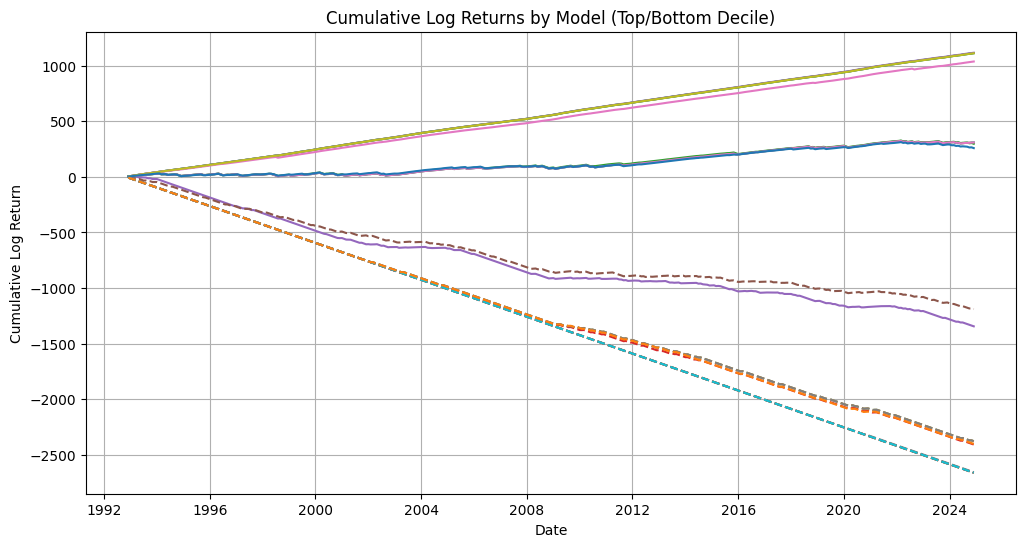

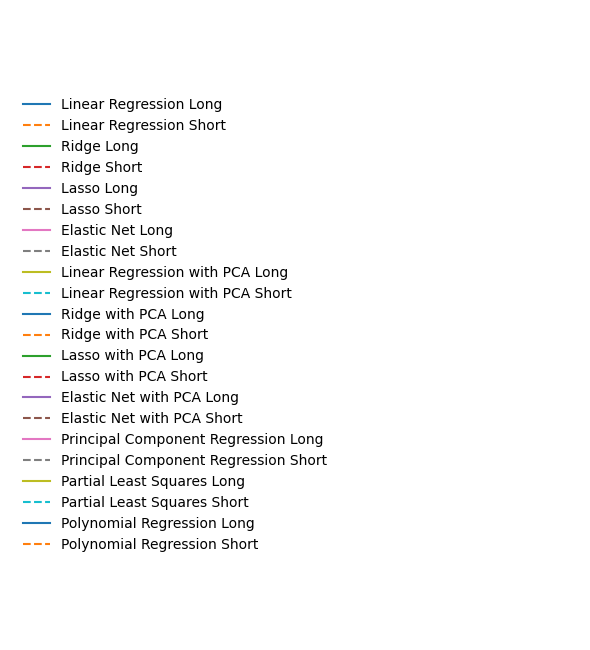

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Store handles and labels to later place them in a separate legend figure
handles = []

for model_name, results in tuned_model_results.items():
    test_preds = results["test_pred"]
    df_test = merged_df_capm.iloc[test_indices].copy()
    df_test["pred"] = test_preds
    df_test["date"] = pd.to_datetime(df_test["date"])

    df_test["decile"] = df_test.groupby("date")["pred"].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates="drop")
    )

    long = df_test[df_test["decile"] == 9]
    short = df_test[df_test["decile"] == 0]

    long_returns = long.groupby("date")["ExcessReturn"].mean()
    short_returns = short.groupby("date")["ExcessReturn"].mean()

    # Clean returns before computing log1p
    long_returns = long_returns.replace([np.inf, -np.inf], np.nan).dropna()
    short_returns = short_returns.replace([np.inf, -np.inf], np.nan).dropna()

    # Clip returns to avoid values < -1
    long_returns = long_returns.clip(lower=-0.999)
    short_returns = short_returns.clip(lower=-0.999)

    long_cumret = np.log1p(long_returns).cumsum()
    short_cumret = np.log1p(short_returns).cumsum()

    long_line, = ax.plot(long_cumret, label=f"{model_name} Long")
    short_line, = ax.plot(short_cumret, linestyle="--", label=f"{model_name} Short")

    handles.extend([long_line, short_line])

# Format plot
ax.set_title("Cumulative Log Returns by Model (Top/Bottom Decile)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Log Return")
ax.grid(True)

fig_leg = plt.figure(figsize=(6, len(handles) * 0.3))
plt.legend(handles=handles, loc="center left", frameon=False)
plt.axis("off")
plt.tight_layout()

plt.show()
